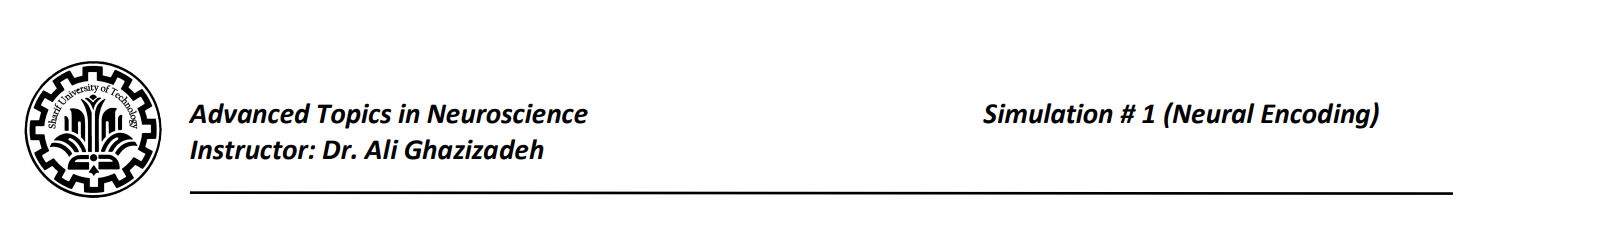

#### Arya Koureshi Hazrat
#### 401204008

---

## Integrate and Fire Neuron 

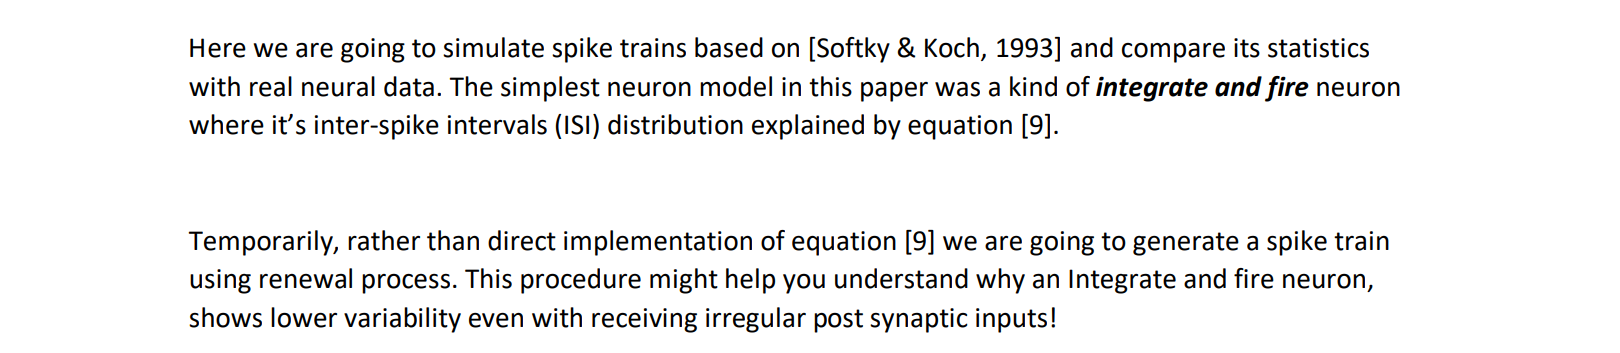

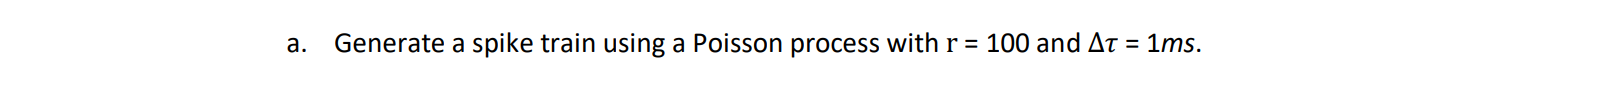

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, expon
import scipy.special as sp
from units import *
from numba import jit, cuda

In [2]:
# part a
r = 100   # firing rate (Hz)
dt = 1e-3 # time step (s)
T = 1 # duration of spike train (s)
n_steps = int(T/dt) # number of steps
n_trials = 25 # number of trials

def poisson_func(r, T, dt):
    n_steps = np.floor(T/dt).astype(int)
    p = r * dt # firing probability
    spikes = np.random.rand(n_steps) < p
    return spikes * 1

def poisson_generator(n_trials, r, T, dt):
    for i in range(n_trials):
        yield poisson_func(r, T, dt)

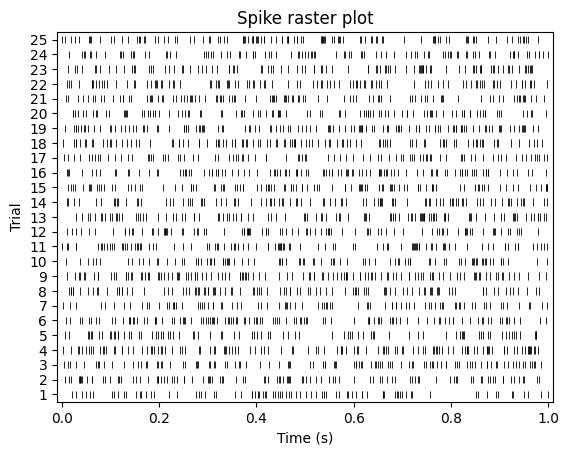

In [3]:
# generate spike trains
spike_trains = list(poisson_generator(n_trials, r, T, dt))

# plot raster plot
for i in range(len(spike_trains)):
    time_spikes = []
    for j in range(len(spike_trains[i])):
        if spike_trains[i][j] == 1: time_spikes.append(j*dt) # extract time of spikes
    plt.eventplot(time_spikes, lineoffsets=i+1, linelengths=0.5, linewidths=0.6, color='k')
    
plt.title('Spike raster plot')
plt.xlabel('Time (s)')
plt.ylabel('Trial')
plt.yticks(range(n_trials+1))
plt.ylim(0.5, n_trials+0.5)
plt.xlim(-0.01, T+0.01)
plt.show()

---

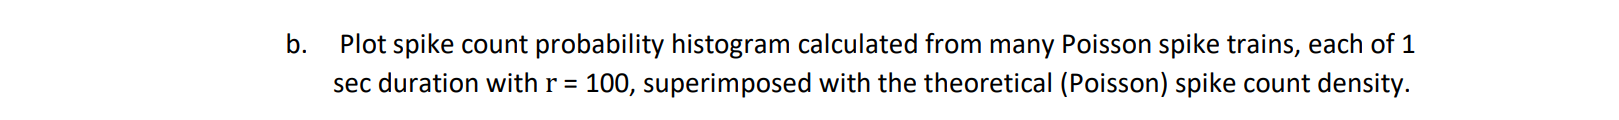

I generated the spike count probability distribution histogram on 10,000 trials, where each trial had a duration of 1 second and a firing rate of 100 Hz.

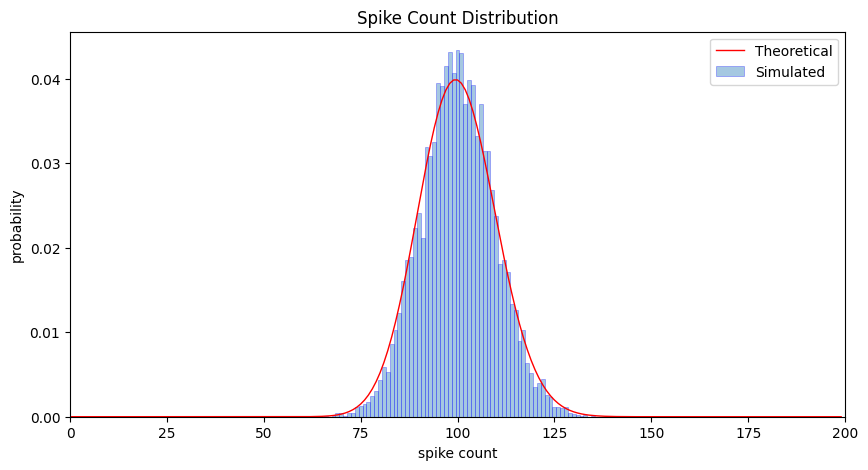

In [4]:
# part b
r = 100   # firing rate (Hz)
dt = 1e-3 # time step (s)
T = 1 # duration of spike train (s)
p = r * dt # firing probability
n_steps = int(T/dt) # number of steps
n_trials = 10000 # number of trials

# calculate spike counts for each spike train
n_spikes = list(map(np.sum, poisson_generator(n_trials, r, T, dt)))
n_spikes = np.array(n_spikes)

plt.figure(figsize=(10,5))
# plot the simulated spike count histogram
bins = np.arange(0, 2*r)
hist, bin_edges = np.histogram(n_spikes, bins=bins, density=True)
plt.bar(bin_edges[:-1], hist, width=1, alpha=0.4, edgecolor='b', linewidth=0.5, label='Simulated')
bin_edges =  np.arange(n_spikes.max() + 1) - 0.5

# plot the theoretical poisson distribution
spike_counts_range = np.arange(0, 2*r)
plt.plot(spike_counts_range, poisson.pmf(spike_counts_range, r*T), 'r', linewidth=1, label='Theoretical')
plt.xlim(0, 2*r)
plt.title("Spike Count Distribution")
plt.xlabel('spike count')
plt.ylabel('probability')
plt.legend()
plt.show()

In [5]:
print("Mean: {}".format(n_spikes.mean()))
print("Variance: {}".format(n_spikes.var()))
print("Rate * train length: {}".format(r * T))

Mean: 100.0628
Variance: 90.24445616
Rate * train length: 100


The mean and variance of this distribution are both equal to the rate times the spike train length.

---

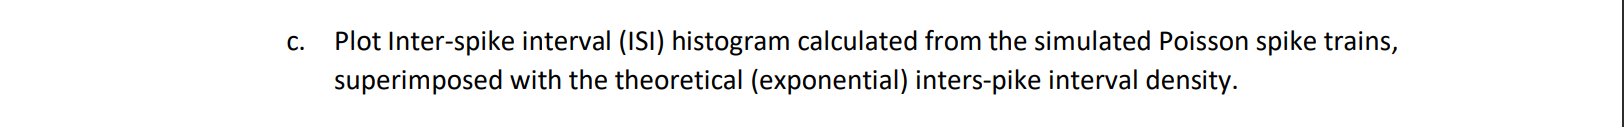

In this section, I am calculating the time interval between each pair of consecutive spikes, which is commonly referred to as Inter-spike intervals (ISIs). This process will result in a vector containing the ISIs for the given set of spikes.

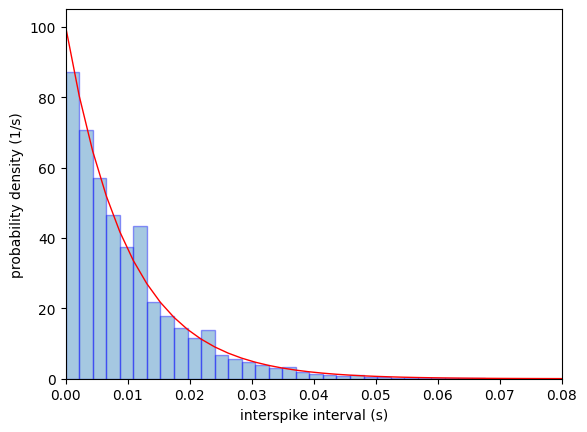

In [7]:
# part c
def exp_pdf(x, lam):
    return lam*np.exp(-lam*x)

r = 100   # firing rate (Hz)
dt = 1e-3 # time step (s)
T = 1000 # duration of spike train (s)

# generate spike train
spike_train = poisson_func(r, T, dt)

# calculate spike times
spt,= np.nonzero(spike_train) # nonzero function of numpy returns indices of all non-zero elements of the array passed in its argument
spt = spt * dt
isi = np.diff(spt) # calculate ISI for spike train

# plot the ISI histogram
isi_bins = np.linspace(0, isi.max(), 50)
plt.hist(isi, isi_bins, density=True, alpha=0.4, edgecolor='b')

# Plot the theoretical exponential distribution
plt.plot(isi_bins, exp_pdf(isi_bins, r), 'r', linewidth=1)
plt.xlabel("interspike interval (s)")
plt.ylabel("probability density (1/s)");
plt.xlim(0, 0.08)
plt.show()

---

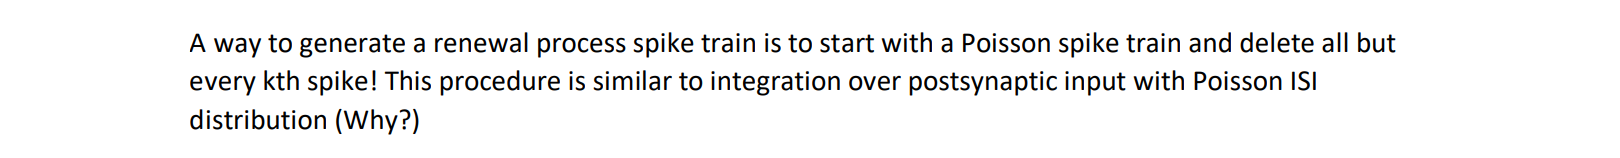

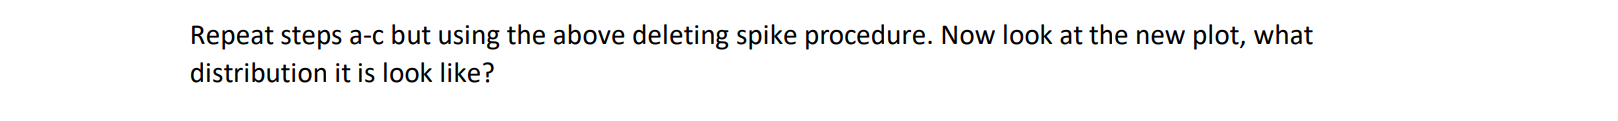

#### part a - renewal

First, I generated a Poisson spike train and then removed all spikes except for every kth spike. Here I assume k is 5. This procedure simulates the integration of pre-synaptic inputs of a neuron with a Poisson-distributed ISI distribution. The resulting raster plots show the spike train before and after the removal operation.

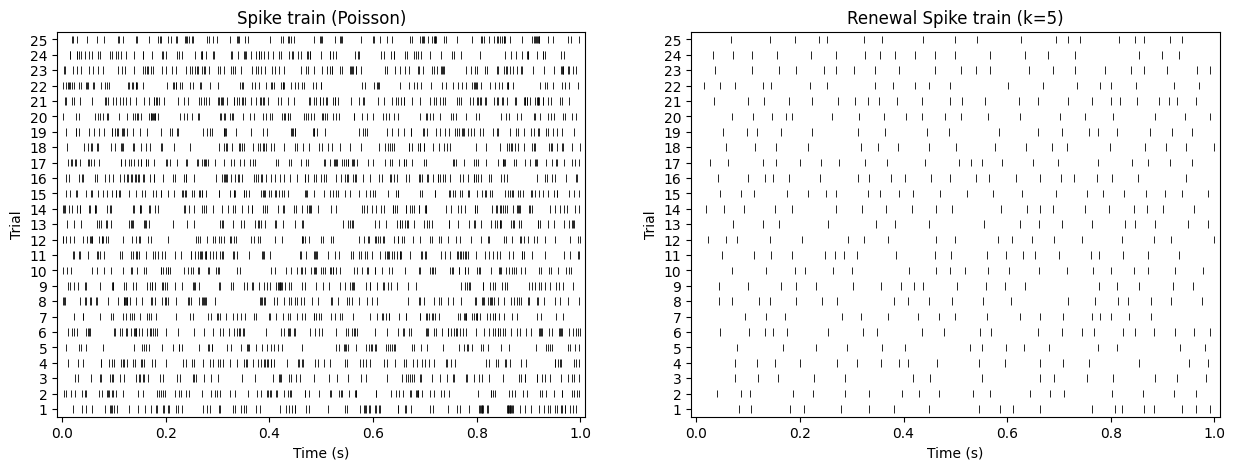

In [8]:
# part a for renewal
r = 100   # firing rate (Hz)
dt = 1e-3 # time step (s)
T = 1 # duration of spike train (s)
p = r * dt # firing probability
n_steps = int(T/dt) # number of steps
n_trials = 25 # number of trials
k = 5 # selecting kth spike

# generate spike trains
spike_trains = list(poisson_generator(n_trials, r, T, dt))

# generate renewal spike trains
renewal_spike_trains = np.zeros((n_trials, n_steps))
for i in range(len(renewal_spike_trains)):
    temp = 0
    for j in range(len(renewal_spike_trains[i])):
        if spike_trains[i][j] == 1: temp += 1
        if temp == k: 
            renewal_spike_trains[i][j] += 1
            temp = 0

# plot raster plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(len(spike_trains)):
    time_spikes = [] 
    for j in range(len(spike_trains[i])):
        if spike_trains[i][j] == 1: time_spikes.append(j*dt) # extract time of spikes
    ax[0].eventplot(time_spikes, lineoffsets=i+1, linelengths=0.5, linewidths=0.6, color='k')
ax[0].set_title('Spike train (Poisson)')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Trial')
ax[0].set_yticks(range(n_trials+1))
ax[0].set_ylim(0.5, n_trials+0.5)
ax[0].set_xlim(-0.01, T+0.01)

for i in range(len(renewal_spike_trains)):
    time_spikes = [] 
    for j in range(len(renewal_spike_trains[i])):
        if renewal_spike_trains[i][j] == 1: time_spikes.append(j*dt) # extract time of spikes
    ax[1].eventplot(time_spikes, lineoffsets=i+1, linelengths=0.5, linewidths=0.6, color='k')
ax[1].set_title('Renewal Spike train (k={})'.format(k))
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Trial')
ax[1].set_yticks(range(n_trials+1))
ax[1].set_ylim(0.5, n_trials+0.5)
ax[1].set_xlim(-0.01, T+0.01)

plt.show()

#### part b - renewal

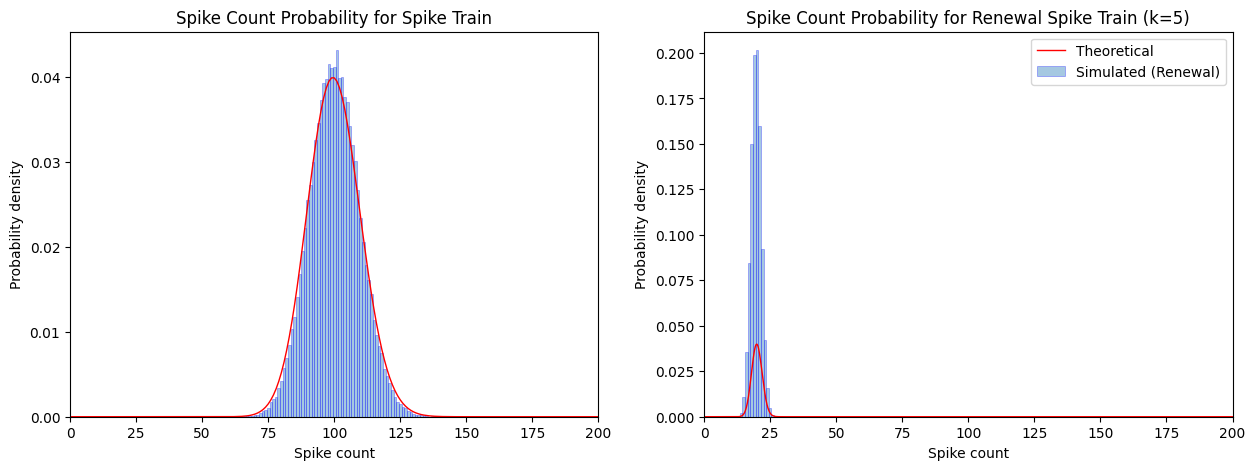

In [61]:
# part b for renewal
r = 100   # firing rate (Hz)
dt = 1e-3 # time step (s)
T = 1 # duration of spike train (s)
n_steps = int(T/dt) # number of steps
n_trials = 100000 # number of trials
k = 5 # selecting kth spike

# generate spike trains
spike_trains = list(poisson_generator(n_trials, r, T, dt))

# generate renewal spike trains
renewal_spike_trains = np.zeros((n_trials, n_steps))
for i in range(len(renewal_spike_trains)):
    temp = 0
    for j in range(len(renewal_spike_trains[i])):
        if spike_trains[i][j] == 1: temp += 1
        if temp == k: 
            renewal_spike_trains[i][j] += 1
            temp = 0
            
# calculate spike counts for each spike train
spike_counts = np.sum(spike_trains, axis=1)
renewal_counts = np.sum(renewal_spike_trains, axis=1)

# plot the simulated spike count histogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bins = np.arange(0, n_trials)
hist, bin_edges = np.histogram(spike_counts, bins=bins, density=True)
ax[0].bar(bin_edges[:-1], hist, width=1, alpha=0.4, edgecolor='b', linewidth=0.5, label='Simulated')

hist_renewal, bin_edges_renewal = np.histogram(renewal_counts, bins=bins, density=True)
ax[1].bar(bin_edges_renewal[:-1], hist_renewal, width=1, alpha=0.4, edgecolor='b', linewidth=0.5, label='Simulated (Renewal)')

# plot the theoretical poisson distribution
spike_counts_range = np.arange(0, n_trials)
ax[0].plot(spike_counts_range, poisson.pmf(spike_counts_range, r*T), 'r', linewidth=1, label='Theoretical')
ax[1].plot(spike_counts_range/k, poisson.pmf(spike_counts_range, r*T), 'r', linewidth=1, label='Theoretical')

ax[0].set_title('Spike Count Probability for Spike Train')
ax[1].set_title('Spike Count Probability for Renewal Spike Train (k={})'.format(k))
ax[0].set_xlim(0, 2*r)
ax[0].set_xlabel('Spike count')
ax[0].set_ylabel('Probability density')
ax[1].set_xlim(0, 2*r)
ax[1].set_xlabel('Spike count')
ax[1].set_ylabel('Probability density')
plt.legend()
plt.show()

#### part c - renewal

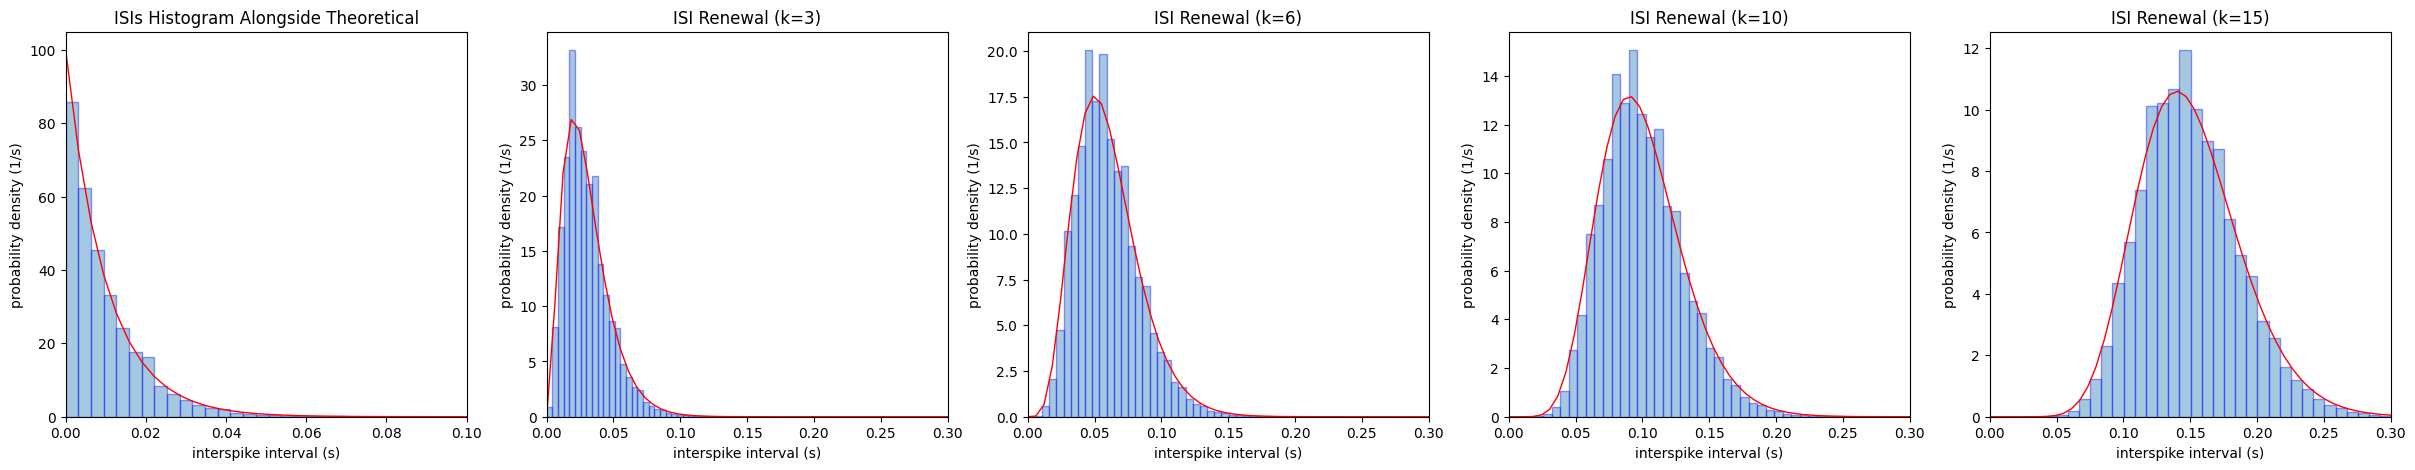

In [9]:
# part c for renewal
def exp_pdf(x, lam):
    return lam*np.exp(-lam*x)

def erlang(x, lam, k):
    return (lam**k * x**(k-1) * np.exp(-lam*x)) / np.math.factorial(k-1)
    
r = 100   # firing rate (Hz)
dt = 1e-3 # time step (s)
T = 100000 # duration of spike train (s)
n_steps = int(T/dt) # number of steps
k = [3, 6, 10, 15] # selecting kth spike

# generate spike train
spike_train = poisson_func(r, T, dt)

# calculate spike times
spt, = np.nonzero(spike_train) # nonzero function of numpy returns indices of all non-zero elements of the array passed in its argument
spt = spt * dt
isi = np.diff(spt) # calculate ISI for spike train
cv = np.std(isi) / np.mean(isi) # CV (coefficient of variation)

# plot the ISI histogram
fig, ax = plt.subplots(1, len(k)+1, figsize=(30, 5))
isi_bins = np.linspace(0, isi.max(), 50)
ax[0].hist(isi, isi_bins, density=True, alpha=0.4, edgecolor='b')

# Plot the theoretical exponential distribution
ax[0].plot(isi_bins, exp_pdf(isi_bins, r), 'r', linewidth=1)
ax[0].set_xlim(0, 0.1)
ax[0].set_title("ISIs Histogram Alongside Theoretical")
ax[0].set_xlabel("interspike interval (s)")
ax[0].set_ylabel("probability density (1/s)")

cv_renewal = []
for j in range(1, len(k)+1):
    # generate renewal spike train
    temp = 0
    renewal_spike_train = np.zeros(np.shape(spike_train))
    for i in range(len(renewal_spike_train)):
        if spike_train[i] != 0:
            temp += 1
            if temp == k[j-1]:
                renewal_spike_train[i] += 1
                temp = 0
    
    # calculate spike times for renewal
    spt_renewal = np.nonzero(renewal_spike_train)
    spt_renewal = spt_renewal[0] * dt
    isi_renewal = np.diff(spt_renewal) # calculate ISI for spike train
    cv_renewal.append(np.std(isi_renewal) / np.mean(isi_renewal)) # CV
    
    isi_bins_renewal = np.linspace(0, isi_renewal.max(), 50)
    erlang_bins = np.linspace(0, 0.3, 50)
    ax[j].hist(isi_renewal, isi_bins_renewal, density=True, alpha=0.4, edgecolor='b')
    ax[j].plot(erlang_bins, erlang(erlang_bins, r, k[j-1]), 'r', linewidth=1)
    ax[j].set_xlim(0, 0.3)
    ax[j].set_title('ISI Renewal (k={})'.format(k[j-1]))
    ax[j].set_xlabel("interspike interval (s)")
    ax[j].set_ylabel("probability density (1/s)")
plt.show()

The spike deletion procedure simulates the integration of post-synaptic inputs. In reality, a post-synaptic neuron requires a certain number of spikes to trigger an action potential. In this simulation, after every kth spike in the input sequence, the post-synaptic neuron receives sufficient input to generate an action potential.

The resulting ISIs histograms show that the distribution after the procedure resembles a gamma distribution.

---

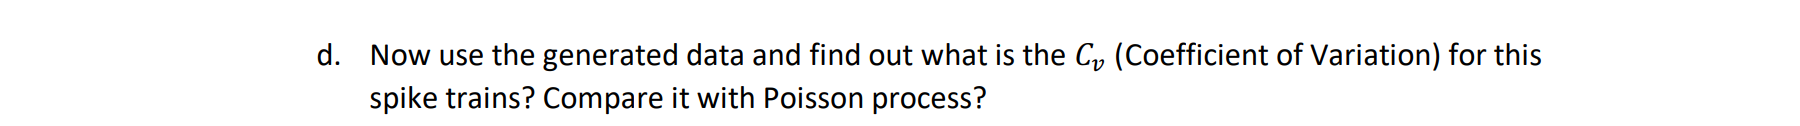

In [10]:
# part d
# CV (coefficient of variation)
print("Coefficient of variation (Poisson): ", cv)
for i in range(len(k)):
    print("Coefficient of variation (Renewal (k={})): ".format(k[i]), cv_renewal[i])

Coefficient of variation (Poisson):  0.9485336244912288
Coefficient of variation (Renewal (k=3)):  0.54740415947917
Coefficient of variation (Renewal (k=6)):  0.3871363493317748
Coefficient of variation (Renewal (k=10)):  0.299855850356647
Coefficient of variation (Renewal (k=15)):  0.24472974206502368


The theoretical coefficient of variation (CV) for a Poisson process is 1. However, when I calculated the CV from the simulated data, I obtained a value of 0.9485 before the spike deletion procedure. After the procedure, for different values of k (3, 6, 10, and 15), the CV values were 0.5474, 0.3871, 0.2998, and 0.2447, respectively. This indicates that the spike deletion procedure affected the variability of the ISI distribution. This shows that increasing the value of k leads to a decrease in the coefficient of variation.

---

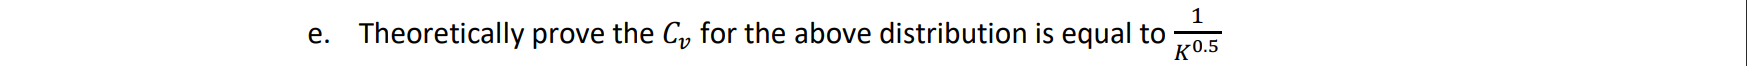

By definition, the inter-spike interval (ISI) of a Poisson process is the sequence $X = (X_1, X_2, ...)$, and the ISI after the spike deletion procedure is $T = (T_1, T_2, ...)$.

$$T_k=\sum_{i=1}^{k} {X_i}$$

The $X_i$'s are independent and identically distributed (i.i.d.) variables with exponential distributions. Therefore:
$$E[T_k]=E[X_1+X_2+X_3+...]=\frac{k}{\lambda}$$
Also:
$$Var[T_k]=Var[X_1+X_2+X_3+...]=\frac{k}{\lambda ^ 2} \to std[T_k]=\frac{\sqrt{k}}{\lambda}$$
So we have:
$$CV=\frac{std[T_k]}{E[T_k]}=\frac{\frac{\sqrt{k}}{\lambda}}{\frac{k}{\lambda}}=\frac{1}{\sqrt{k}}$$

---

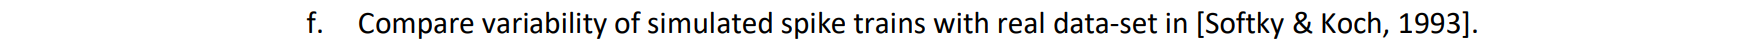

According to Figure 3 in the Softky and Koch paper, the system exhibits non-stationarity, with the coefficient of variation (CV) changing depending on the average inter-spike interval (ISI). At lower firing rates in V1, the CV ranges from 0.5 to 1, while at higher firing rates it is less than 0.5. This indicates that the variability of real data differs from that of simulated data, possibly due to neuronal firing adaptation.

---

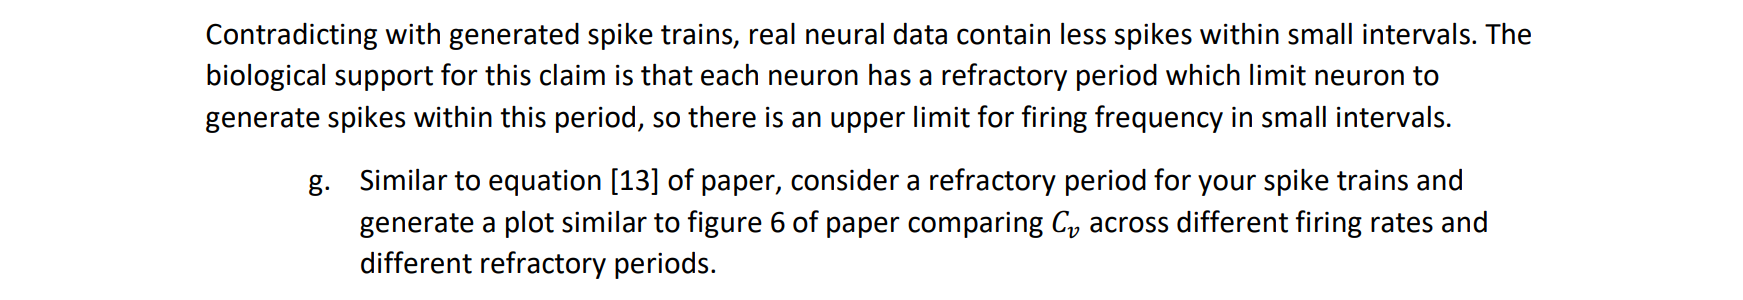

Based on the equation [14] of the paper, we can reconstruct the figure 6 of the paper:
$$Equation  [14]:  CV=\frac{1}{\sqrt{N_{th}}}(\frac{\overline{\Delta t}-t_0}{\overline{\Delta t}})$$ 

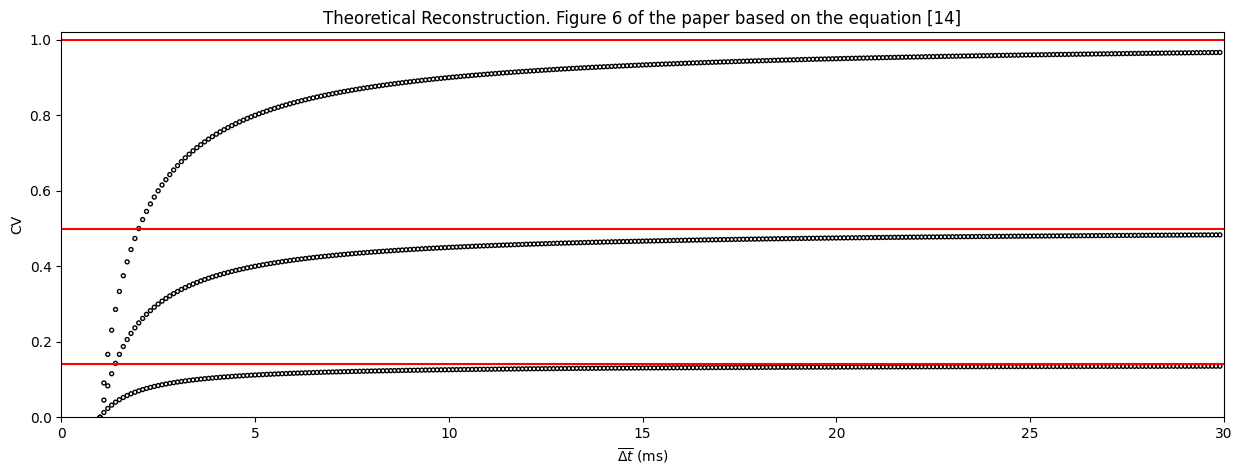

In [11]:
# part g
# equation 14 of paper
def CV_calculator(k, dt, t0):
    return (1/np.sqrt(k))*((dt-t0)/dt)

T = 30 # ms
dt = 1e-1 
t0 = 1 # refractory period (ms)
k = [1, 4, 51]

time = np.arange(t0, T, dt)
fig = plt.figure(figsize=(15,5))
for i in range(len(k)):
    for j in range(len(time)):
        plt.scatter(time[j], CV_calculator(k[i], time[j], t0), marker='o', fc='none', edgecolor='k', s=8)
    plt.plot((1/np.sqrt(k[i]))*np.ones(T+1), 'r', markersize=0.5)
plt.xlim(0, T)
plt.ylim(0, 1.02)
plt.title('Theoretical Reconstruction. Figure 6 of the paper based on the equation [14]')
plt.ylabel('CV')
plt.xlabel(r'$\overline{\Delta t}$ (ms)');

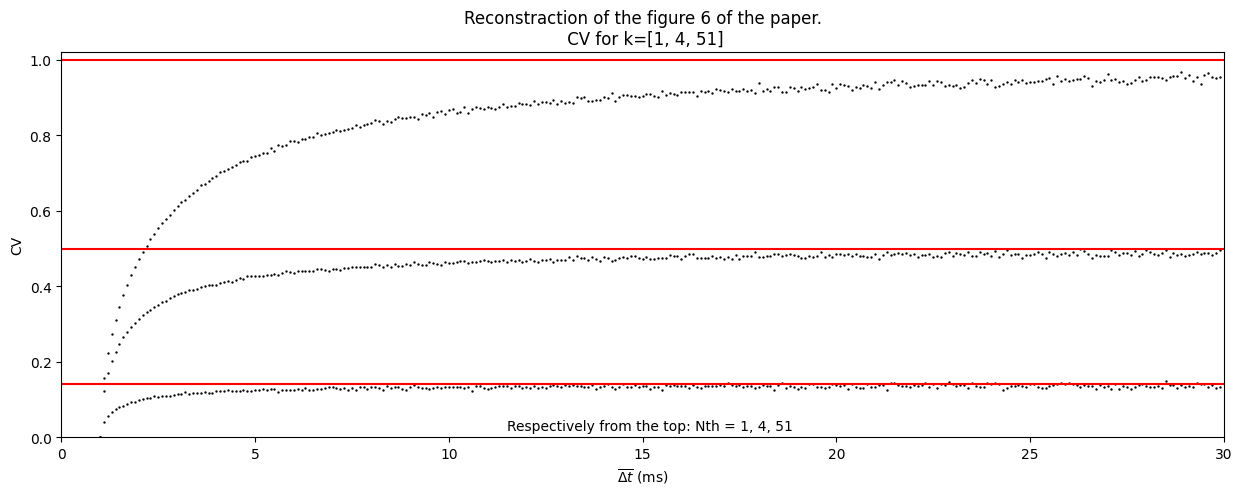

In [12]:
dt = 1e-3 # time step (s)
T = 500 # duration of spike train (s)

k = [1, 4, 51] # selecting kth spike
delta_t = np.arange(1e-3, 30e-3, 1e-4) # 1 / firing rate
t0 = 1e-3 # refractory period (ms)

fig = plt.figure(figsize=(15,5))
for kk in k:
    cv_renewal = []
    for r in delta_t:        
        # generate spike train
        spike_train = poisson_func(1/r, T, dt)
        
        # generate renewal spike train
        temp = 0
        renewal_spike_train = np.zeros(np.shape(spike_train))
        for i in range(len(renewal_spike_train)):
            if spike_train[i] != 0:
                temp += 1
                if temp == kk:
                    renewal_spike_train[i] += 1
                    temp = 0
        
        # calculate spike times for renewal
        spt_renewal = np.nonzero(renewal_spike_train)
        spt_renewal = spt_renewal[0] * dt
        isi_renewal = np.diff(spt_renewal) + t0 # calculate ISI for spike train
        cv_renewal.append(np.std(isi_renewal) / np.mean(isi_renewal)) # CV

    plt.scatter(delta_t * 1e3, cv_renewal, marker='.', c='k', s=2)
    plt.plot((1/np.sqrt(kk))*np.ones(30+1), 'r', markersize=0.5)

plt.xlim(0, 30)
plt.ylim(0, 1.02)
plt.title('Reconstraction of the figure 6 of the paper.\n CV for k={}'.format(k))
plt.text(11.5, 0.02, 'Respectively from the top: Nth = 1, 4, 51')
plt.ylabel('CV')
plt.xlabel(r'$\overline{\Delta t}$ (ms)');

All plots starts from their specific refractory period and are smaller than the $\frac{1}{\sqrt{N_{th}}}$

---

## Leaky Integrate and Fire Neuron 

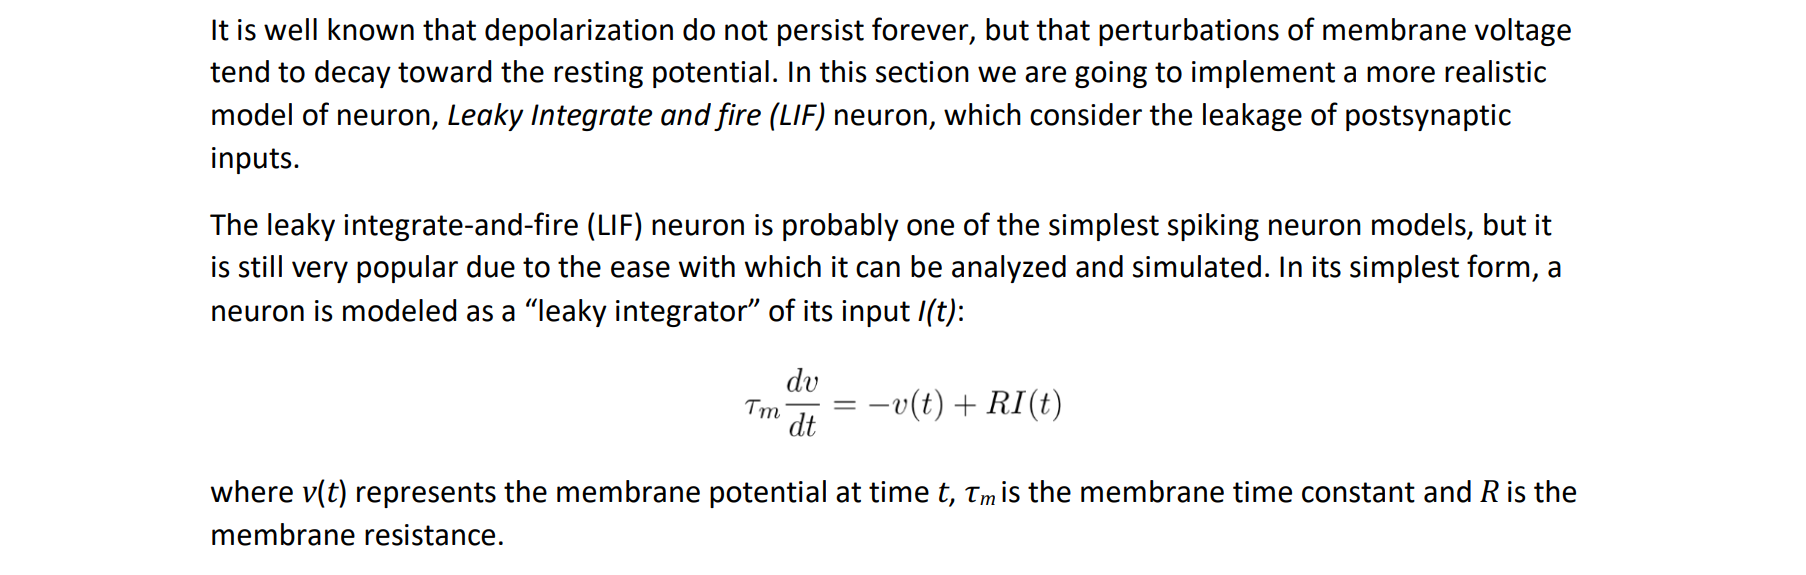

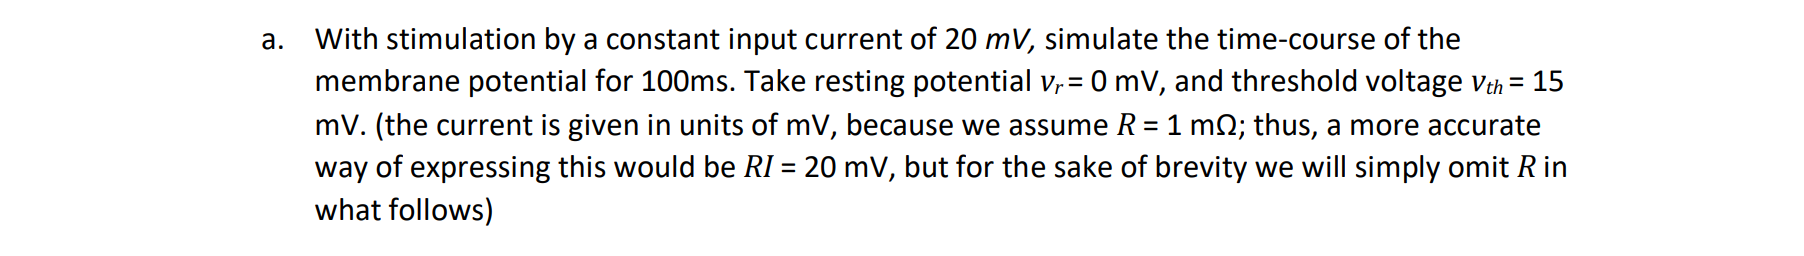

$\tau_{m}=10ms$

$v_{th}=15mv$

$v_{r}=0mv$

$RI=20mv$

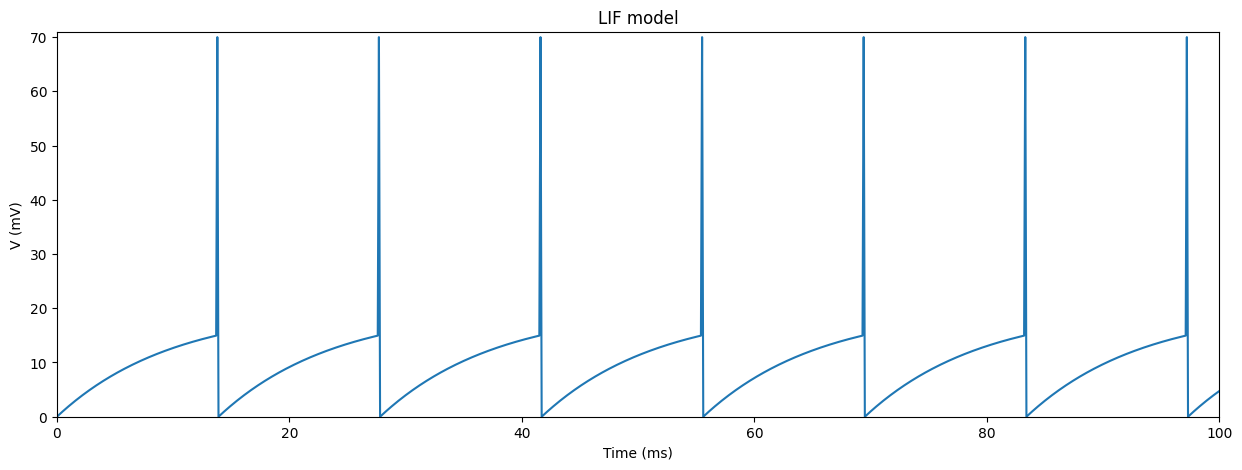

In [13]:
# part a
dt = 0.1e-3 # time step (ms)
T = 1 # duration of spike train (s)
t = np.arange(0, T, dt)
R = 1
Vth = 15e-3 # mV
Vr = 0 # mV
Vspike = 70e-3 # mV
tau_m = 10e-3 # ms
V0 = Vr
I0 = 20e-3 # mA

# constant input current
def I(t, I0):
    return I0*np.ones(np.size(t))

# defining LIF
def LIF(tau_m, Vr, Vth, R, V0, I):
    spike = 0
    for i in range(0, np.size(t)-1):
        V[i+1] = V[i] + (1/tau_m) * (-V[i] + (R * I[i])) * dt
        if V[i] >= Vth:
            V[i] = Vspike
            V[i+1] = Vr
            spike += 1
    return V, spike

V = np.zeros(np.size(t))
I = I(t, I0)
[V, spike] = LIF(tau_m, Vr, Vth, R, V0, I) 

# plot
fig = plt.figure(figsize=(15, 5))
plt.plot(t*1e3, V*1e3)
plt.xlim(0, T*100)
plt.ylim(Vr*1e3, Vspike*1e3+1)
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.title("LIF model");

---

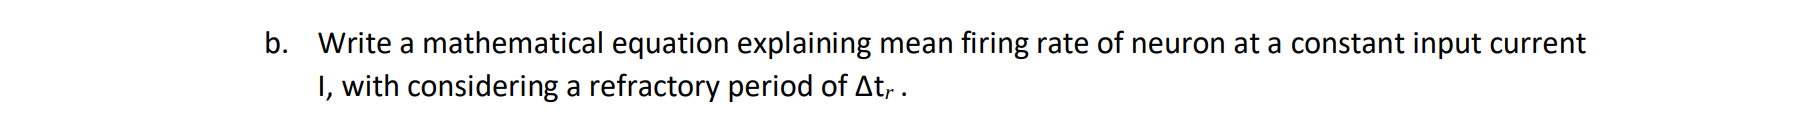

$\large v(t)=RI(1-e^\frac{-t}{\tau_{m}})$


$\large v(t)=v_{th} \to RI(1-e^\frac{-t}{\tau_{m}})=v_{th} \to 1-\frac{v_{th}}{RI}=e^\frac{-t}{\tau_{m}} \to t={-\tau_{m}}\ln{(1-\frac{v_{th}}{RI})}$


$\large T=t+\Delta t_{r}$
$\large \to \frac{1}{T}=f=\frac{1}{{-\tau_{m}}\ln{(1-\frac{v_{th}}{RI})}+\Delta t_{r}}$

By increasing the membrane time constant (τm), the frequency of spiking decreases.

---

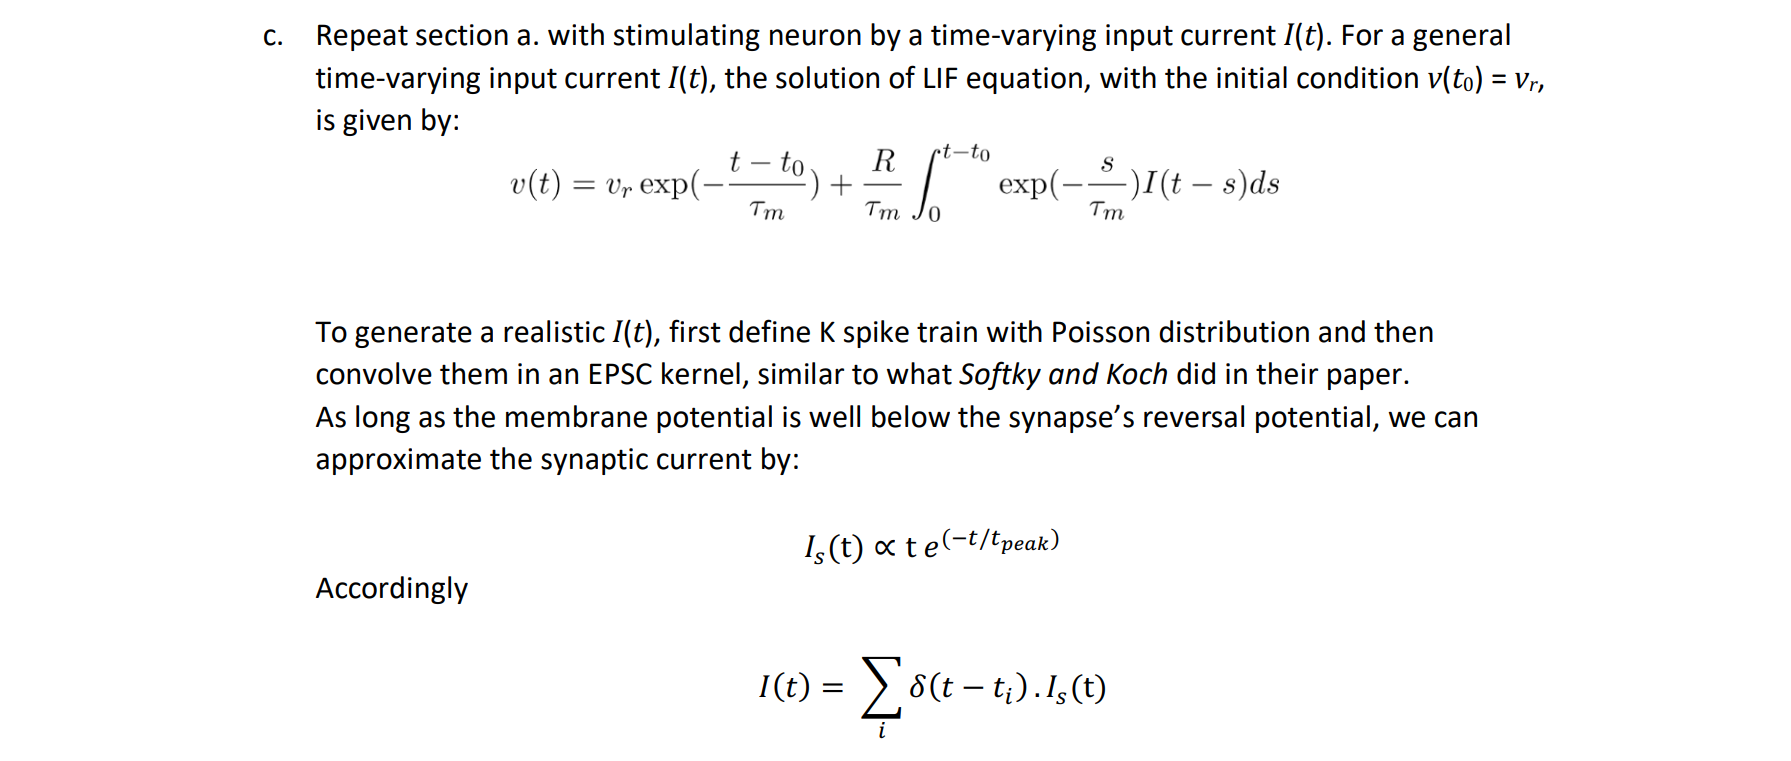
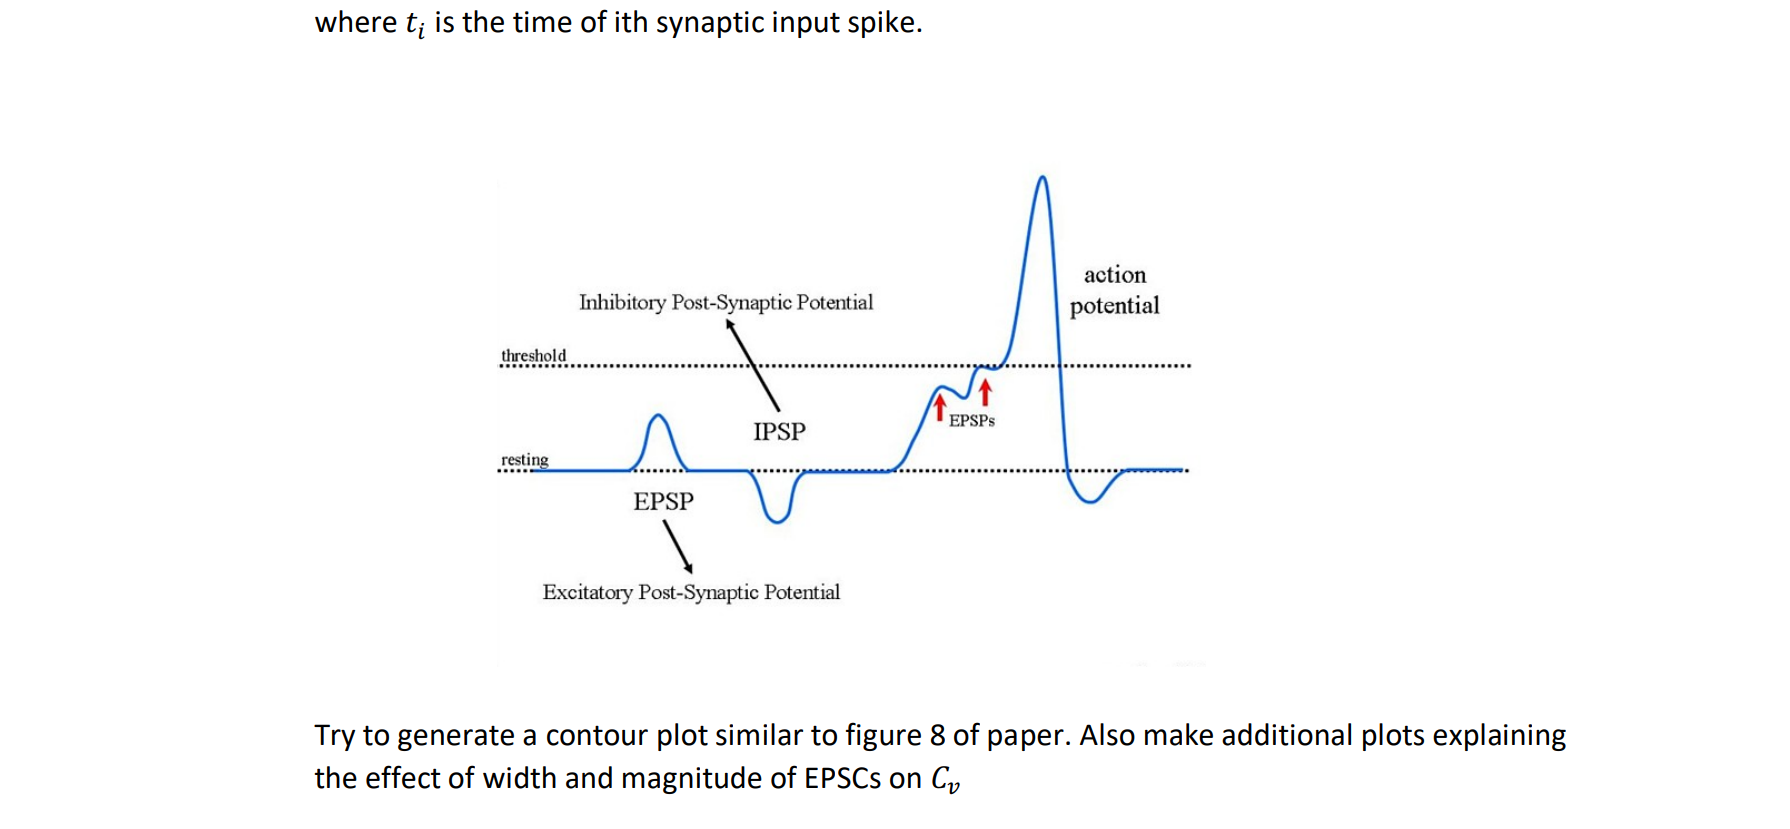

$\tau_{m}=10ms$

$v_{th}=15mv$

$v_{r}=0mv$

$RI=20mv$

$\tau_{peak}=5ms$

$f_r=100Hz$

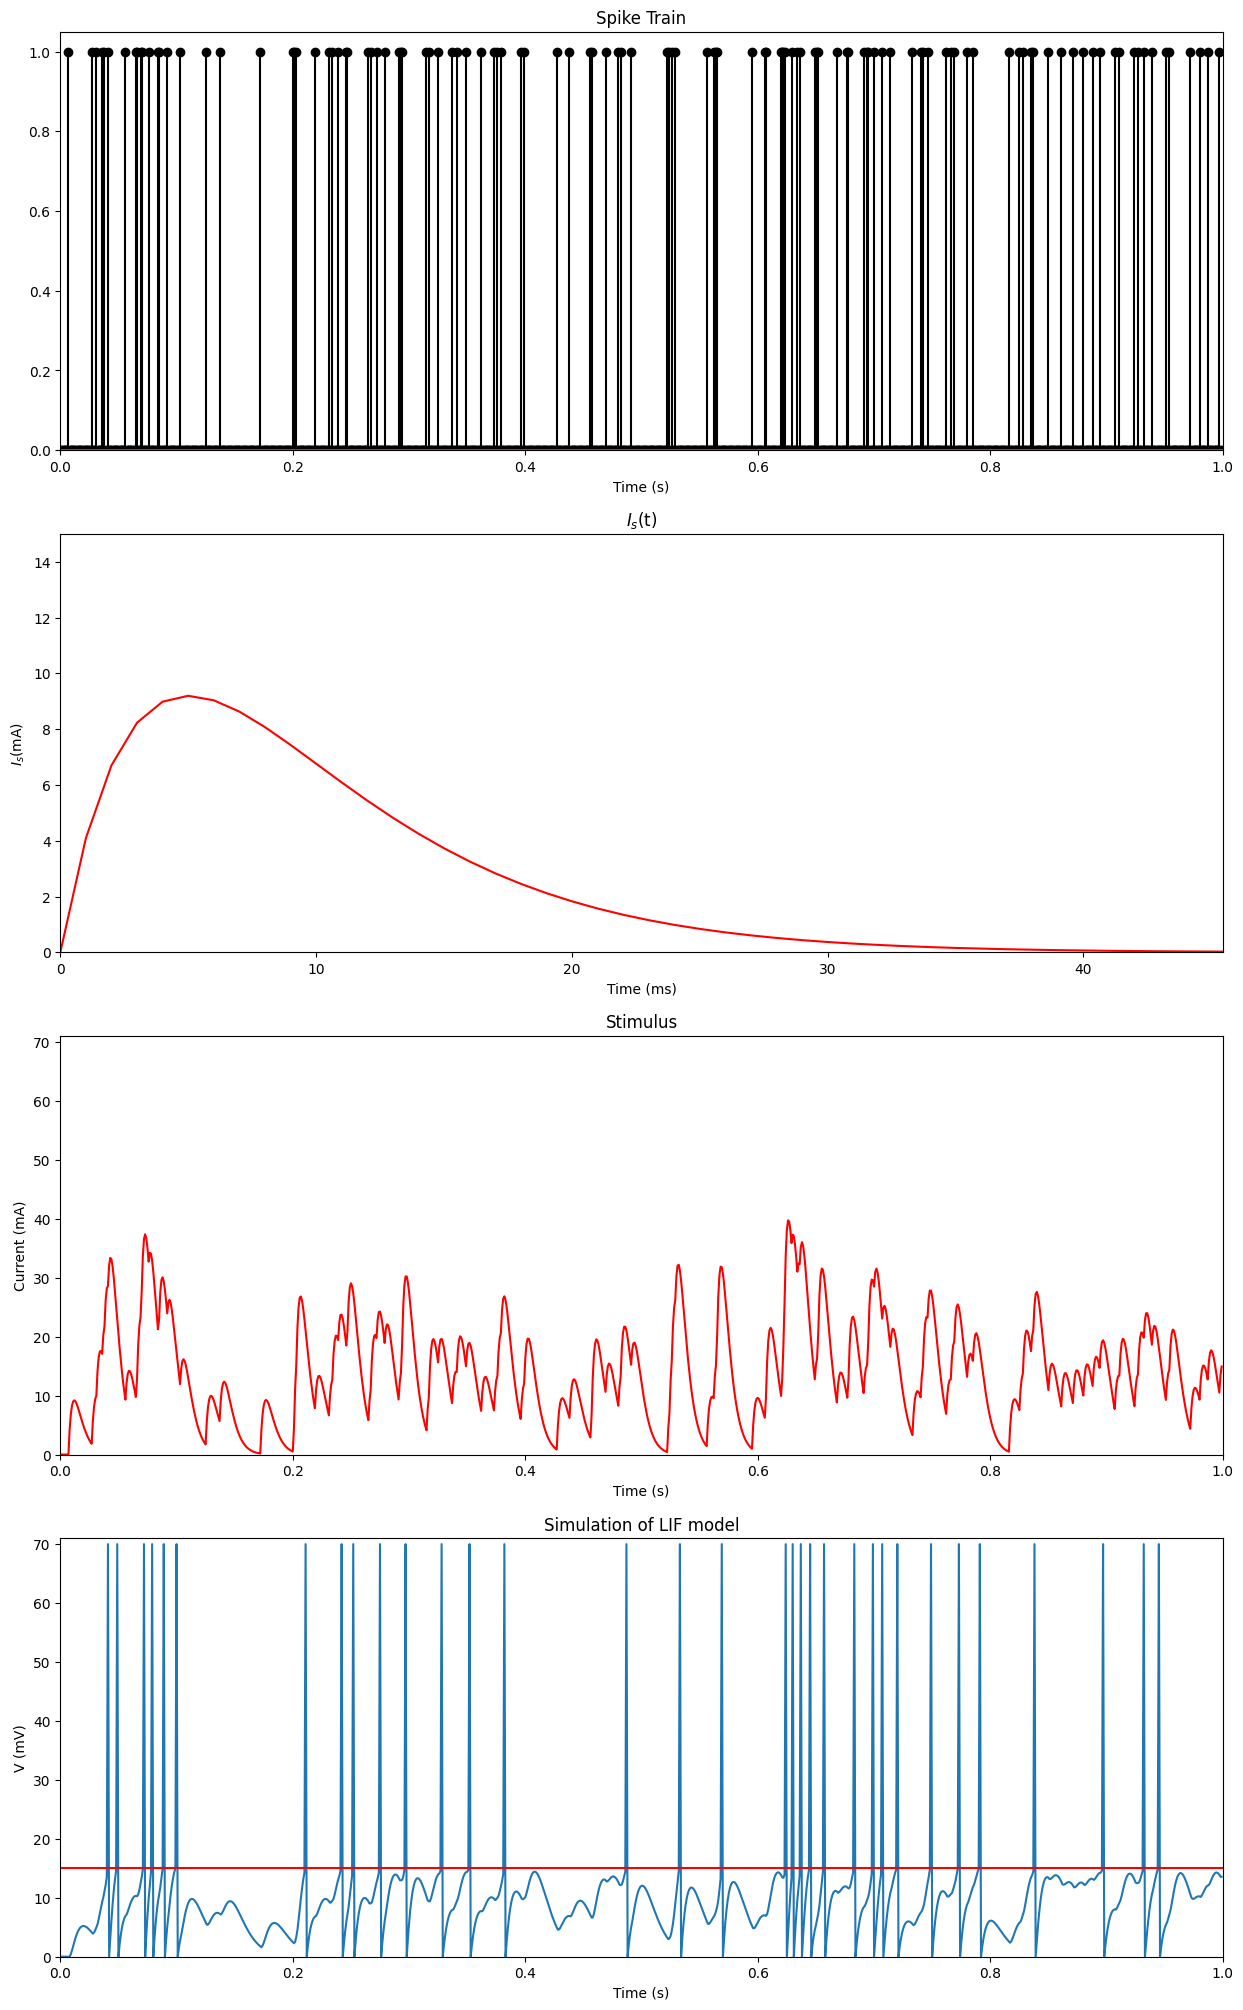

In [14]:
# part c
r = 100 # Hz
dt = 1e-3 # time step (ms)
T = 1 # duration of spike train (s)
t = np.arange(0, T, dt) # time
t_peak = 5e-3 # ms
R = 1
Vth = 15e-3 # mV
Vr = 0 # mV
Vspike = 70e-3 # mV
tau_m = 10e-3 # ms
V0 = Vr
I0 = 5 # mA

# EPSC kernel
def EPSC(t, t_peak, I0):
    return I0*t*np.exp(-t/t_peak)

# defining LIF
def LIF(tau_m, Vr, Vth, R, V0, I):
    spt = [] # spike times
    spike = 0
    for i in range(0, np.size(t)-1):
        V[i+1] = V[i] + (1/tau_m) * (-V[i] + (R * I[i])) * dt
        if V[i] >= Vth:
            V[i] = Vspike
            V[i+1] = Vr
            spike += 1
            spt.append(i * dt)
    return V, spike, spt

# generate spike train
spike_train = poisson_func(r, T, dt) # shape = (1000,)

# generate stimulus
Is = EPSC(t, t_peak, I0)
stimulus = np.convolve(Is, spike_train)

V = np.zeros(np.size(t))
[V, spike, spt] = LIF(tau_m, Vr, Vth, R, V0, stimulus)

fig, ax = plt.subplots(4, 1, figsize=(15,25))
ax[0].stem(t, spike_train, 'k')
ax[0].set_title("Spike Train")
ax[0].set_xlim(0, T)
ax[0].set_ylim(0, 1.05)
ax[0].set_xlabel("Time (s)")

ax[1].plot(t*1e3, Is*1e3, 'red')
ax[1].set_title(r'$I_s$(t)')
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel(r'$I_s$(mA)')
ax[1].set_xlim(0, T*1e3/22)
ax[1].set_ylim(0, I0+10)

ax[2].plot(t, stimulus[:len(t)]*1e3, 'red')
ax[2].set_title("Stimulus")
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel('Current (mA)')
ax[2].set_xlim(0, T)
ax[2].set_ylim(Vr*1e3, Vspike*1e3+1)

ax[3].plot(t, V*1e3)
ax[3].plot(Vth*1e3*np.ones(len(t)), 'r', markersize=0.5)
ax[3].set_title("Simulation of LIF model")
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('V (mV)')
ax[3].set_xlim(0, T)
ax[3].set_ylim(Vr*1e3, Vspike*1e3+1);

#### CV Contour

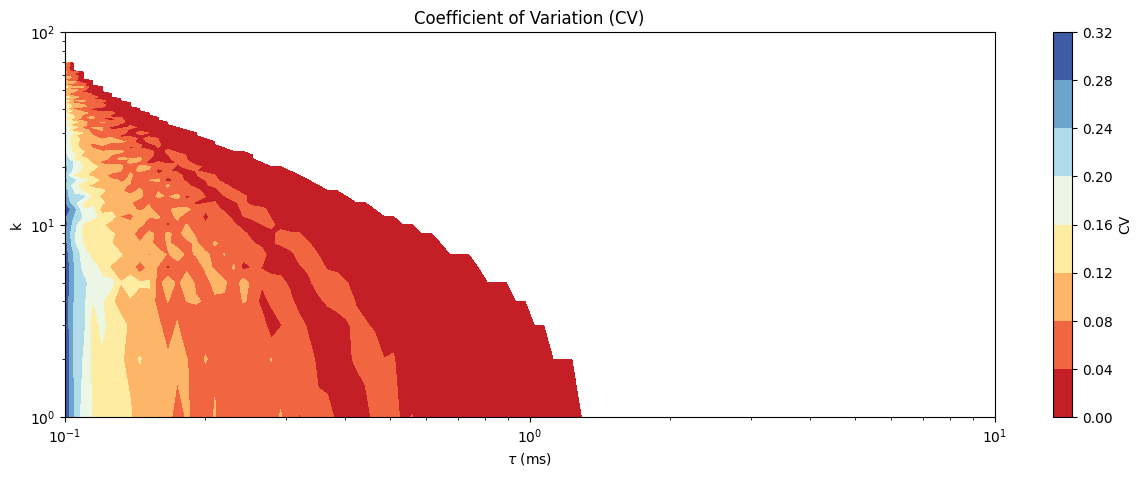

In [95]:
# contour plot
r = 200 # Hz
dt = 1e-3 # time step (ms)
T = 10 # duration of spike train (s)
t = np.arange(0, T, dt) # time
t_peak = 5e-3 # ms
t0 = 1e-3 # refractory period (ms)
R = 1
Vth = 15e-3 # mV
Vr = 0 # mV
Vspike = 70e-3 # mV
V0 = Vr
I0 = 5 # mA

# EPSC kernel
def EPSC(t, t_peak, I0):
    return I0*t*np.exp(-t/t_peak)

# defining LIF
def LIF(tau_m, Vr, Vth, R, V0, I):
    spt = [] # spike times
    spike = 0
    for i in range(0, np.size(t)-1):
        V[i+1] = V[i] + (1/tau_m) * (-V[i] + (R * I[i])) * dt
        if V[i] >= Vth:
            V[i] = Vspike
            V[i+1] = Vr
            spike += 1
            spt.append(i * dt)
    return V, spike, spt

# generate spike train
spike_train = poisson_func(r, T, dt)

Is = EPSC(t, t_peak, I0)

# generate stimulus
stimulus = np.convolve(Is, spike_train)

tau_range = np.logspace(-1, 1, 100)
k_range = range(1, 101)

cv = np.zeros((len(tau_range), len(k_range)))
for k in k_range:
    for tau in range(len(tau_range)):
        V = np.zeros(np.size(t))
        [V, spike, spt] = LIF(tau_range[tau], Vr, Vth, R, V0, stimulus)
        
        # generate renewal spikes from simulated LIF model
        spt_renewal = []
        for i in range(1, len(spt)):
            if i%k == 0:
                spt_renewal.append(spt[i])
        
        # calculate spike times
        isi_renewal = np.diff(spt_renewal) + t0 # calculate ISI for spike train
        cv[tau][k-1] += (np.std(isi_renewal) / np.mean(isi_renewal)) # CV (coefficient of variation)
    
# plot contour
fig, ax = plt.subplots(figsize=(15,5))
cs = ax.contourf(tau_range, k_range, cv, cmap='RdYlBu')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\tau$ (ms)')
ax.set_ylabel('k')
ax.set_title('Coefficient of Variation (CV)')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('CV')
plt.show()

**CV Contour**

In this part, I introduced a refractory period of 1ms to the neurons and varied the parameter τm, which controls the decay speed of the EPSPs. The results were obtained for values of Nth ranging from 1 to 100, τm ranging from 0.1ms to 10ms, and the firing rate of 200Hz.

* Due to computational constraints, I chose a value of T=10 for the simulations. However, this caused the coefficient of variation to become NaN for values of τm greater than 1, which resulted in poor plot quality. Increasing T to 100 would allow for better simulation results and plot visualization.

The CV increases as Nth decreases, indicating an inverse relationship between Nth and CV. This pattern is consistent with Figure [8] in the paper, where increasing EPSC amplitude (moving from top right to bottom left) corresponds to larger CV values.

#### Effect of magnitude and width of EPSCs on CV

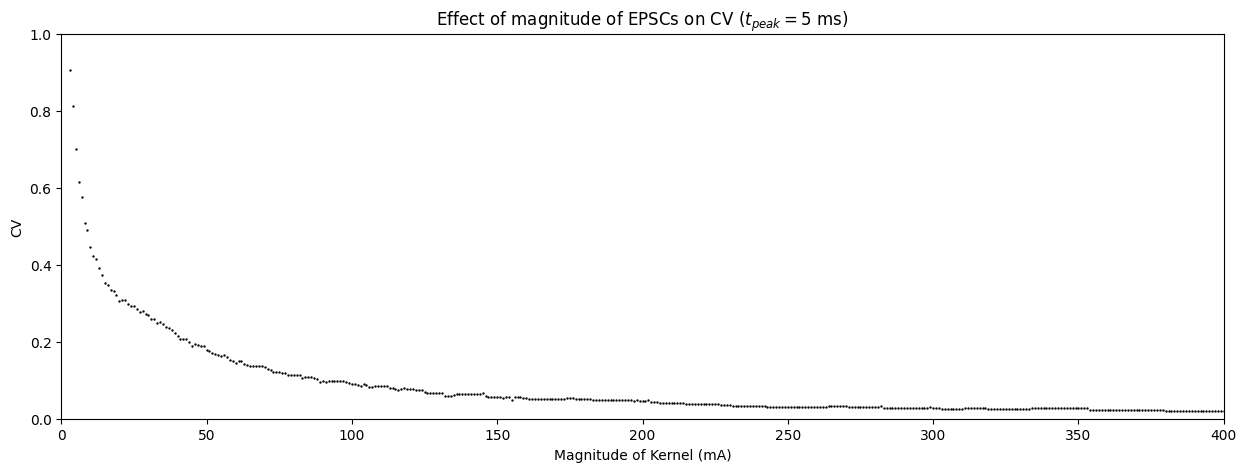

In [16]:
# effect of magnitude of EPSCs on cv
r = 200 # Hz
dt = 1e-3 # time step (ms)
T = 10 # duration of spike train (s)
t = np.arange(0, T, dt) # time
t_peak = 5e-3 # ms
t0 = 1e-3 # refractory period (ms)
R = 1
Vth = 15e-3 # mV
Vr = 0 # mV
Vspike = 70e-3 # mV
tau_m = 10e-3 # ms
V0 = Vr

I0 = range(1, 401) # mA

# EPSC kernel
def EPSC(t, t_peak, I0):
    return I0*t*np.exp(-t/t_peak)

# defining LIF
def LIF(tau_m, Vr, Vth, R, V0, I):
    spt = [] # spike times
    spike = 0
    for i in range(0, np.size(t)-1):
        V[i+1] = V[i] + (1/tau_m) * (-V[i] + (R * I[i])) * dt
        if V[i] >= Vth:
            V[i] = Vspike
            V[i+1] = Vr
            spike += 1
            spt.append(i * dt)
    return V, spike, spt

# generate spike train
spike_train = poisson_func(r, T, dt) # shape = (1000,)

fig = plt.figure(figsize=(15,5))
for i in I0:
    # generate stimulus
    Is = EPSC(t, t_peak, i)
    stimulus = np.convolve(Is, spike_train)

    V = np.zeros(np.size(t))
    [V, spike, spt] = LIF(tau_m, Vr, Vth, R, V0, stimulus)
    isi = np.diff(spt) + t0 # calculate ISI for spike train
    cv = (np.std(isi) / np.mean(isi)) # CV (coefficient of variation)
    
    plt.scatter(i, cv, marker='.', c='k', s=2)
plt.title(r'Effect of magnitude of EPSCs on CV ($t_{}={}$ ms)'.format("{peak}", int(t_peak *1e3)))
plt.ylabel('CV')
plt.xlabel('Magnitude of Kernel (mA)')
plt.xlim(0, I0[-1])
plt.ylim(0, 1);

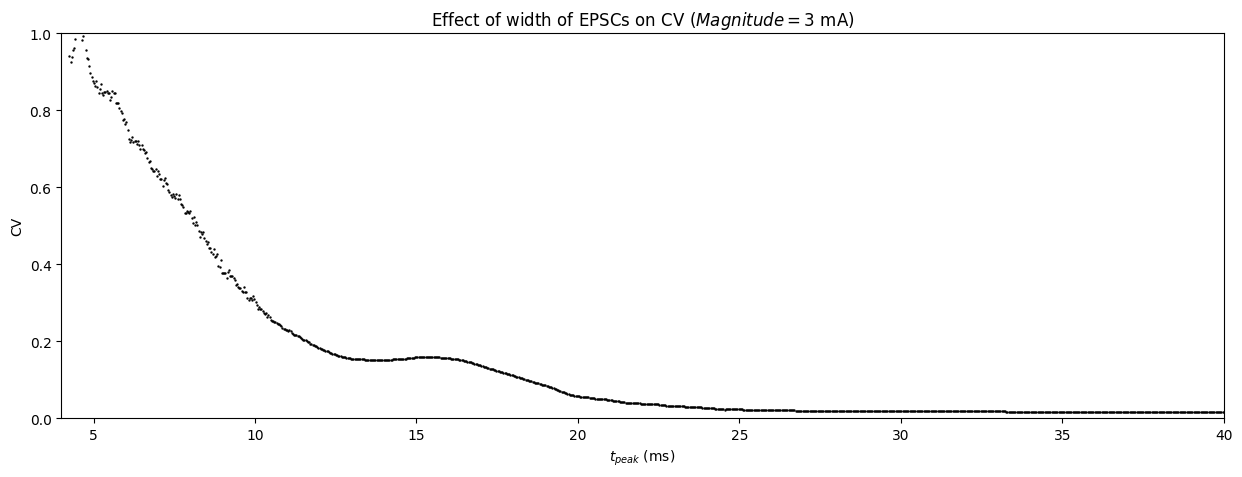

In [17]:
# effect of width of EPSCs on cv
r = 200 # Hz
dt = 1e-3 # time step (ms)
T = 10 # duration of spike train (s)
t = np.arange(0, T, dt) # time
t0 = 1e-3 # refractory period (ms)
R = 1
Vth = 15e-3 # mV
Vr = 0 # mV
Vspike = 70e-3 # mV
tau_m = 10e-3 # ms
V0 = Vr
I0 = 3 # mA

t_peak = np.linspace(4e-3, 40e-3, 1000) # ms

# EPSC kernel
def EPSC(t, t_peak, I0):
    return I0*t*np.exp(-t/t_peak)

# defining LIF
def LIF(tau_m, Vr, Vth, R, V0, I):
    spt = [] # spike times
    spike = 0
    for i in range(0, np.size(t)-1):
        V[i+1] = V[i] + (1/tau_m) * (-V[i] + (R * I[i])) * dt
        if V[i] >= Vth:
            V[i] = Vspike
            V[i+1] = Vr
            spike += 1
            spt.append(i * dt)
    return V, spike, spt

# generate spike train
spike_train = poisson_func(r, T, dt) # shape = (1000,)
fig = plt.figure(figsize=(15,5))
for tp in t_peak:
    # generate stimulus
    Is = EPSC(t, tp, I0)
    stimulus = np.convolve(Is, spike_train)

    V = np.zeros(np.size(t))
    [V, spike, spt] = LIF(tau_m, Vr, Vth, R, V0, stimulus)
    isi = np.diff(spt) + t0 # calculate ISI for spike train
    cv = (np.std(isi) / np.mean(isi)) # CV (coefficient of variation)
    
    plt.scatter(tp*1e3, cv, marker='.', c='k', s=2)
plt.title(r'Effect of width of EPSCs on CV ($Magnitude={}$ mA)'.format(int(I0)))
plt.ylabel('CV')
plt.xlabel(r'$t_{peak}$ (ms)')
plt.xlim(t_peak[0]*1e3, t_peak[-1]*1e3)
plt.ylim(0, 1);

The expectation is that increasing the width and amplitude of the EPSCs will lead to a decrease in CV, as it brings the system closer to periodic behavior.

---

#### Including Inhibitory Inputs

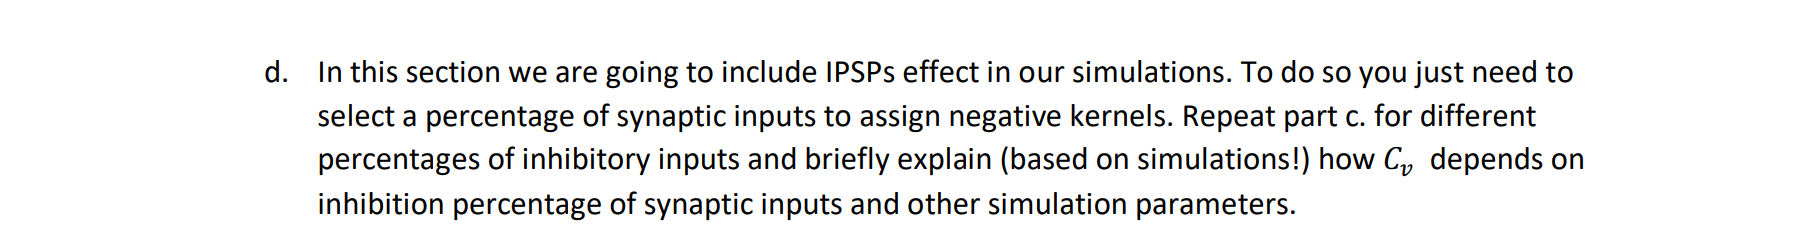

In this section, I utilized 10 trials, each with a firing rate of 100Hz and a duration of 1 second, instead of 10 inputs. I assumed each trial to be a single input, which can be either inhibitory or excitatory. The results for the percentages of inhibitory inputs (20%, 40%, 60%, and 80%) are shown below.

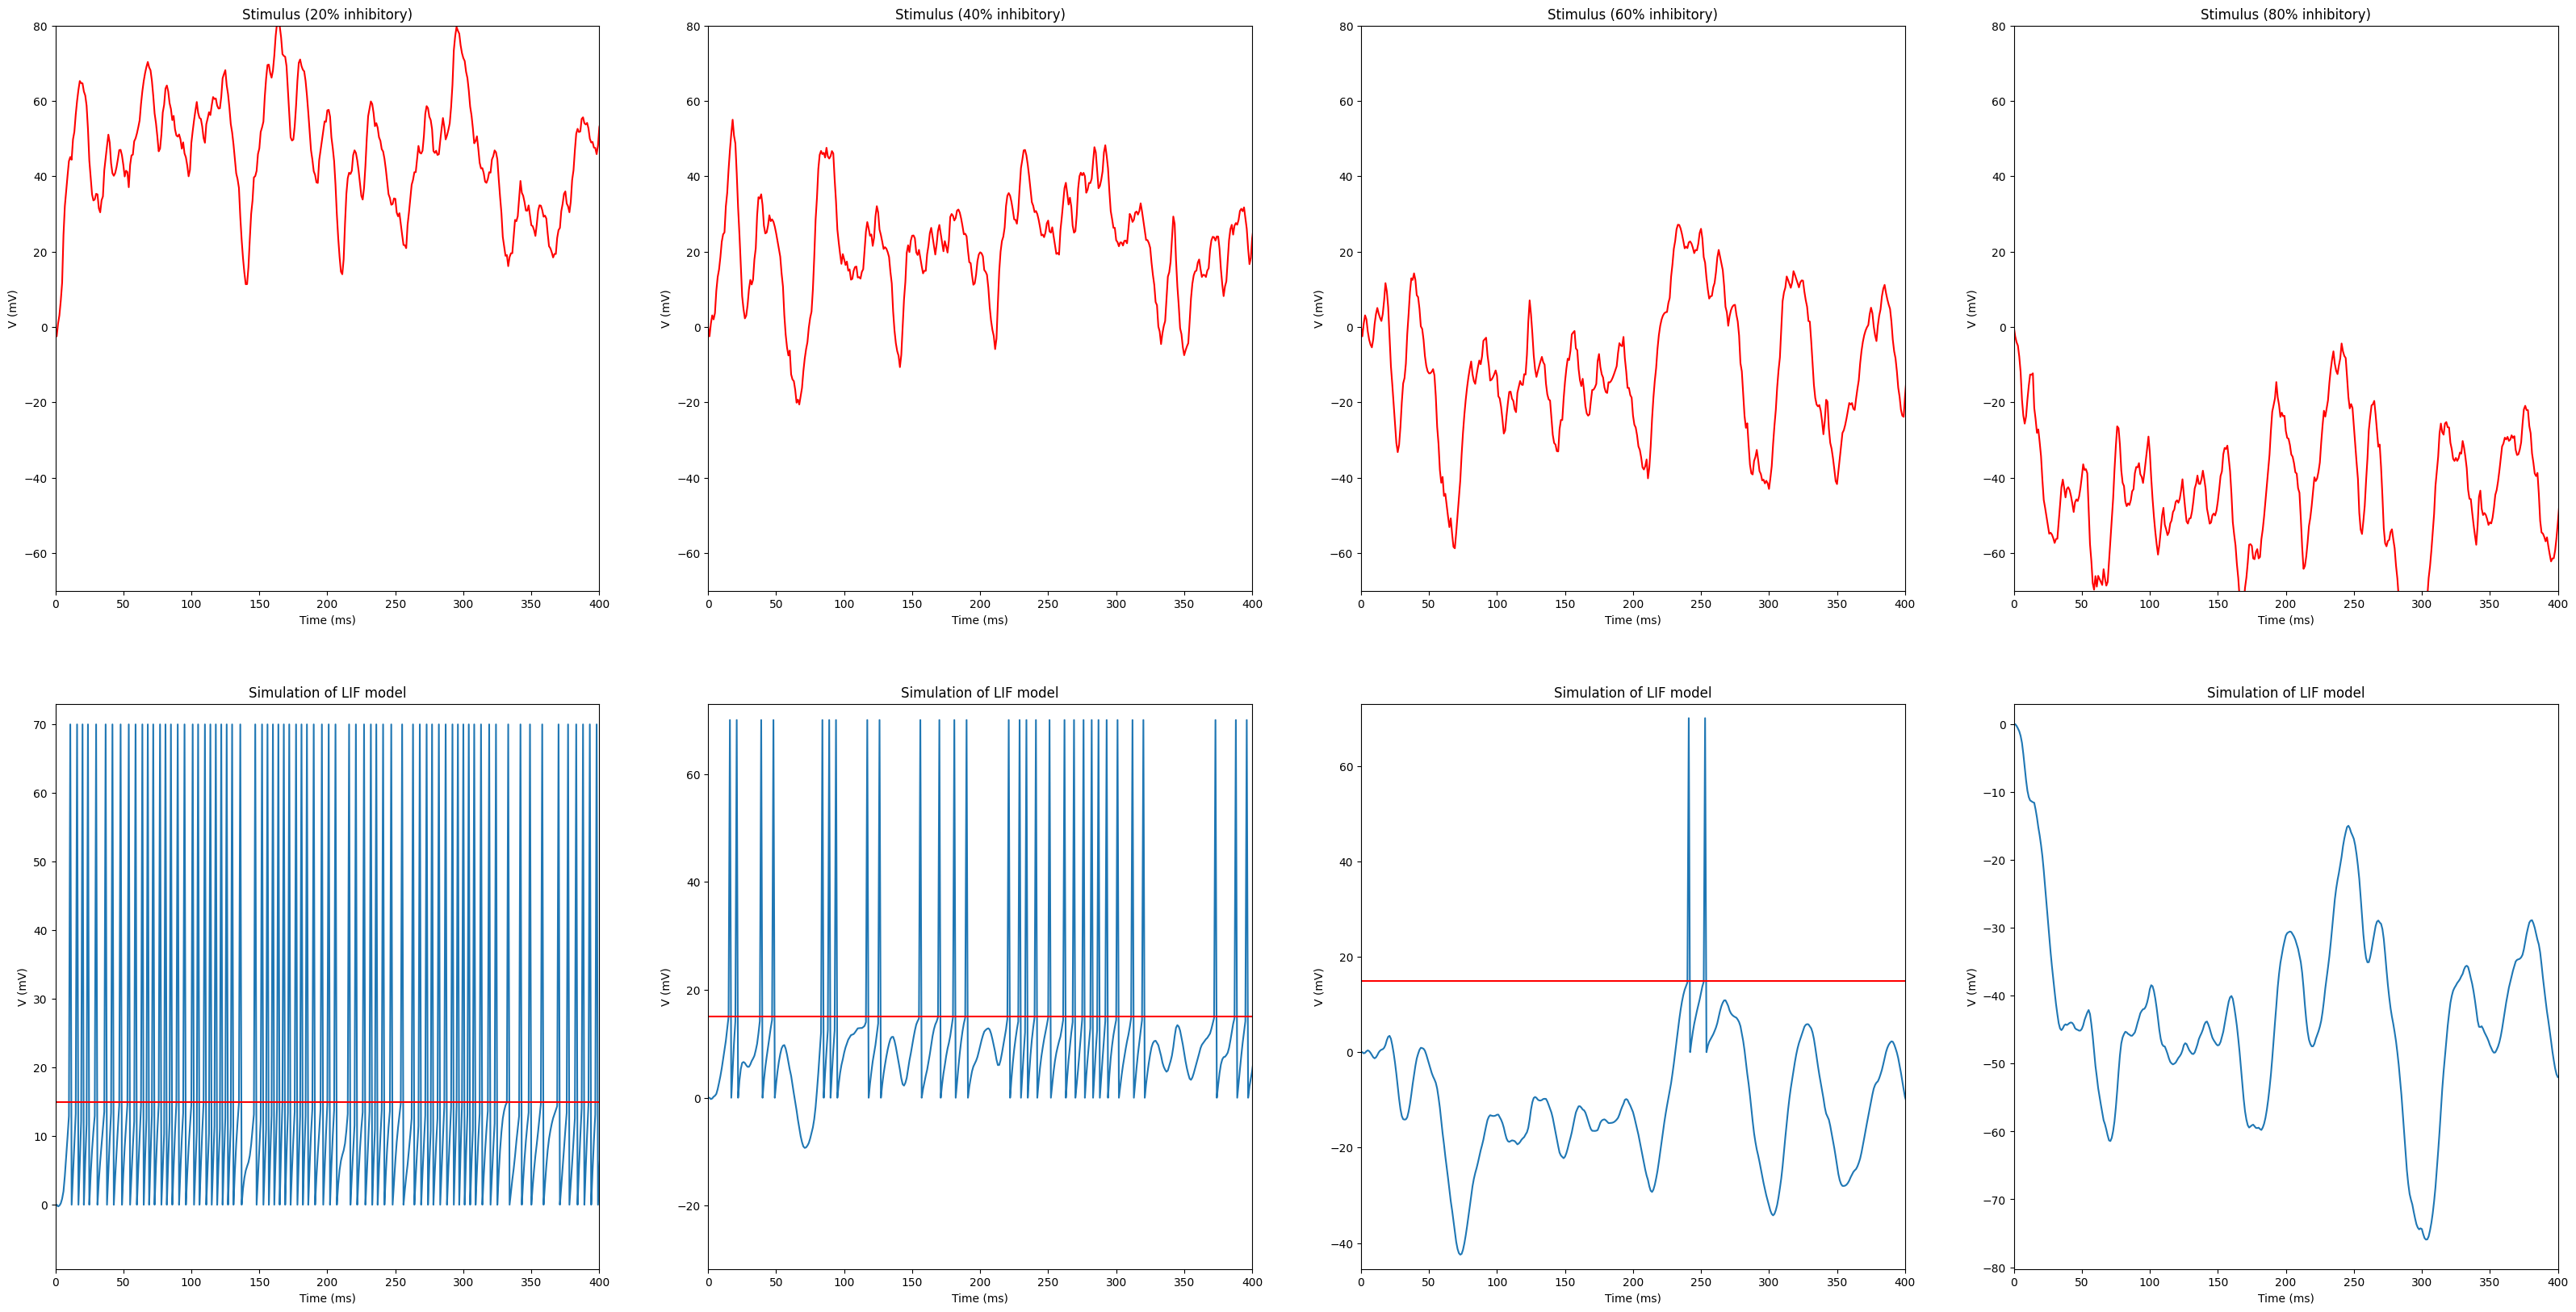

In [18]:
# part d
p_inh = [20, 40, 60, 80] # percentage of inhibitory inputs
r = 100 # Hz
dt = 1e-3 # time step (ms)
T = 1 # duration of spike train (s)
t = np.arange(0, T, dt) # time
t0 = 1e-3 # refractory period (ms)
R = 1
Vth = 15e-3 # mV
Vr = 0 # mV
Vspike = 70e-3 # mV
tau_m = 10e-3 # ms
V0 = Vr
I0 = 3 # mA
t_peak = 5e-3 # ms
n_trials = 10

# EPSC kernel
def EPSC(t, t_peak, I0):
    return I0*t*np.exp(-t/t_peak)

# defining LIF
def LIF(tau_m, Vr, Vth, R, V0, I):
    spt = [] # spike times
    spike = 0
    for i in range(0, np.size(t)-1):
        V[i+1] = V[i] + (1/tau_m) * (-V[i] + (R * I[i])) * dt
        if V[i] >= Vth:
            V[i] = Vspike
            V[i+1] = Vr
            spike += 1
            spt.append(i * dt)
    return V, spike, spt

# genearate spike trains and Is
spike_trains = list(poisson_generator(n_trials, r, T, dt))
Is = EPSC(t, t_peak, I0)

fig, ax = plt.subplots(2, len(p_inh), figsize=(40,20))
for p in range(len(p_inh)):
    # generate stimuli (inhibitories and exitatory)
    stimuli = []
    # inhibitories
    for i in range(int(n_trials*p_inh[p]/100)):
        stimuli.append(-1 * np.convolve(Is, spike_trains[i]))

    # exitatories
    for i in range(int(n_trials*p_inh[p]/100), n_trials):
        stimuli.append(np.convolve(Is, spike_trains[i]))

    # sum all of the stimuli
    I_final = np.sum(stimuli, axis=0)

    V = np.zeros(np.size(t))
    [V, spike, spt] = LIF(tau_m, Vr, Vth, R, V0, I_final)

    ax[0][p].plot(t*1000, I_final[:len(t)]*1e3, 'red')
    ax[0][p].set_title("Stimulus ({}% inhibitory)".format(p_inh[p]))
    ax[0][p].set_xlabel("Time (ms)")
    ax[0][p].set_ylabel('V (mV)')
    ax[0][p].set_xlim(0, T*400)
    ax[0][p].set_ylim(-70, 80)
    
    ax[1][p].plot(t*1000, V*1e3)
    ax[1][p].plot(Vth*1e3*np.ones(len(t)), 'r', markersize=0.5)
    ax[1][p].set_title("Simulation of LIF model")
    ax[1][p].set_xlabel('Time (ms)')
    ax[1][p].set_ylabel('V (mV)')
    ax[1][p].set_xlim(0, T*400)
    ax[1][p].set_ylim(np.min(V)*1e3-3, np.max(V)*1e3+3);

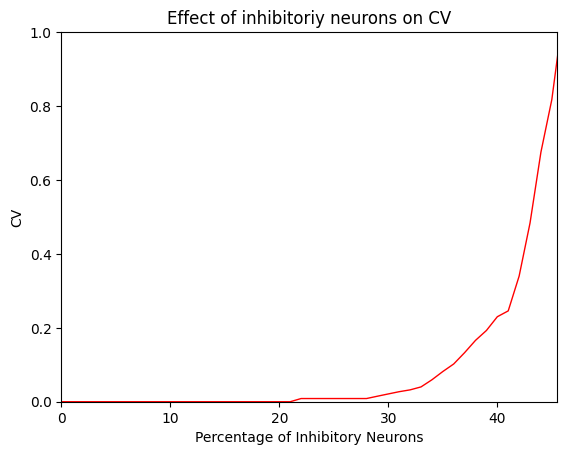

In [20]:
# part d (cv vs percentage of inhibitories)
p_inh = np.arange(0, 51, 1) # percentage of inhibitory inputs
r = 100 # Hz
dt = 1e-3 # time step (ms)
T = 3 # duration of spike train (s)
t = np.arange(0, T, dt) # time
t0 = 1e-3 # refractory period (ms)
R = 1
Vth = 15e-3 # mV
Vr = 0 # mV
Vspike = 70e-3 # mV
tau_m = 10e-3 # ms
V0 = Vr
I0 = 3 # mA
t_peak = 5e-3 # ms
n_trials = 100

# EPSC kernel
def EPSC(t, t_peak, I0):
    return I0*t*np.exp(-t/t_peak)

# defining LIF
def LIF(tau_m, Vr, Vth, R, V0, I):
    spt = [] # spike times
    spike = 0
    for i in range(0, np.size(t)-1):
        V[i+1] = V[i] + (1/tau_m) * (-V[i] + (R * I[i])) * dt
        if V[i] >= Vth:
            V[i] = Vspike
            V[i+1] = Vr
            spike += 1
            spt.append(i * dt)
    return V, spike, spt

# genearate spike trains and Is
spike_trains = list(poisson_generator(n_trials, r, T, dt))
Is = EPSC(t, t_peak, I0)

cv = []
for p in range(len(p_inh)):
    # generate stimuli (inhibitories and exitatory)
    stimuli = []
    # inhibitories
    for i in range(int(n_trials*p_inh[p]/100)):
        stimuli.append(-1 * np.convolve(Is, spike_trains[i]))
    # exitatories
    for i in range(int(n_trials*p_inh[p]/100), n_trials):
        stimuli.append(np.convolve(Is, spike_trains[i]))

    # sum all of the stimuli
    I_final = np.sum(stimuli, axis=0)

    V = np.zeros(np.size(t))
    [V, spike, spt] = LIF(tau_m, Vr, Vth, R, V0, I_final)
    
    isi = np.diff(spt) + t0 # calculate ISI
    cv.append(np.std(isi) / np.mean(isi)) # CV (coefficient of variation)
plt.plot(p_inh, cv, 'r', linewidth=1) #marker='.', c='k', s=2)
plt.title('Effect of inhibitoriy neurons on CV')
plt.ylabel('CV')
plt.xlabel('Percentage of Inhibitory Neurons')
plt.xlim(p_inh[0], 45.5)
plt.ylim(0, 1);

The results show that as the percentage of inhibitory inputs increases, the total input becomes more negative, leading to a decrease in firing rate. The addition of inhibitory inputs can increase the CV, consistent with the findings of Shadlen and Newsome.

---

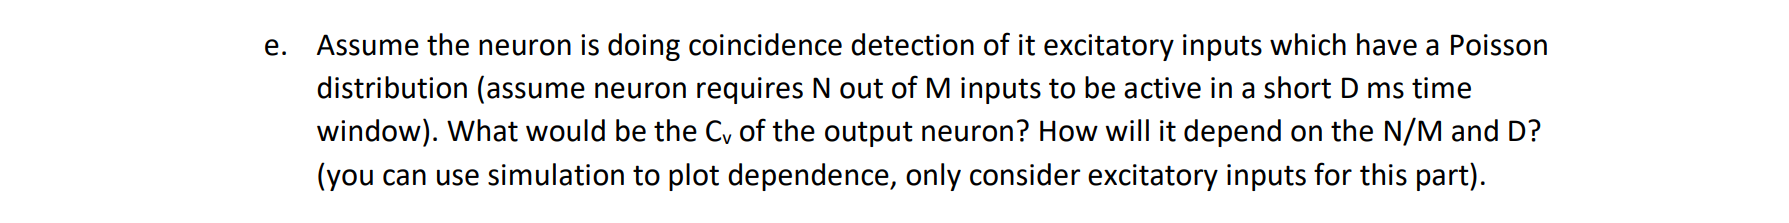

In this section, I computed the CV for window lengths ranging from 10 to 100, with k values of [1, 4, 7, 20]. The CV was averaged over 100 trials, and the results are presented below.

In [ ]:
# part e
Duration = 1e3 # ms
r = 100 # Hz
dt = 1e-3
t0 = 0.001 # refractory period ms
W = np.arange(10, 101) # window
N = np.arange(0, int(5*r*max(W)/Duration)+1)
CV = np.zeros((100, len(W), len(N)))

# Perform simulation
for cv in range(len(CV)):
    spt = [] # time spikes
    tt = 0
    cnt = 0 # count spikes
    t = 0
    isi = []

    # Generate spikes by utilizing an exponential distribution
    while t < Duration/1000:
        isi.append(np.random.exponential(1/r) + t0)
        t += isi[cnt]
        spt.append(t)
        cnt += 1
    spt = spt[:-1]
    
    # Perform coincidence detection
    spt_final = []
    for w in range(len(W)):
        for n in range(len(N)):
            tt = 0
            spt_final = []
            while tt < Duration:
                Nfind = np.where((np.array(spt)*1000 >= tt) & (np.array(spt)*1000 < tt+W[w]))[0]
                tt += W[w]
                if(len(Nfind) == N[n]):
                    spt_final.append(tt/1000)
            if (len(spt_final) > 1):
                CV[cv, w, n] = np.std(np.diff(spt_final))/np.mean(np.diff(spt_final))

CV = np.mean(CV, axis=0)

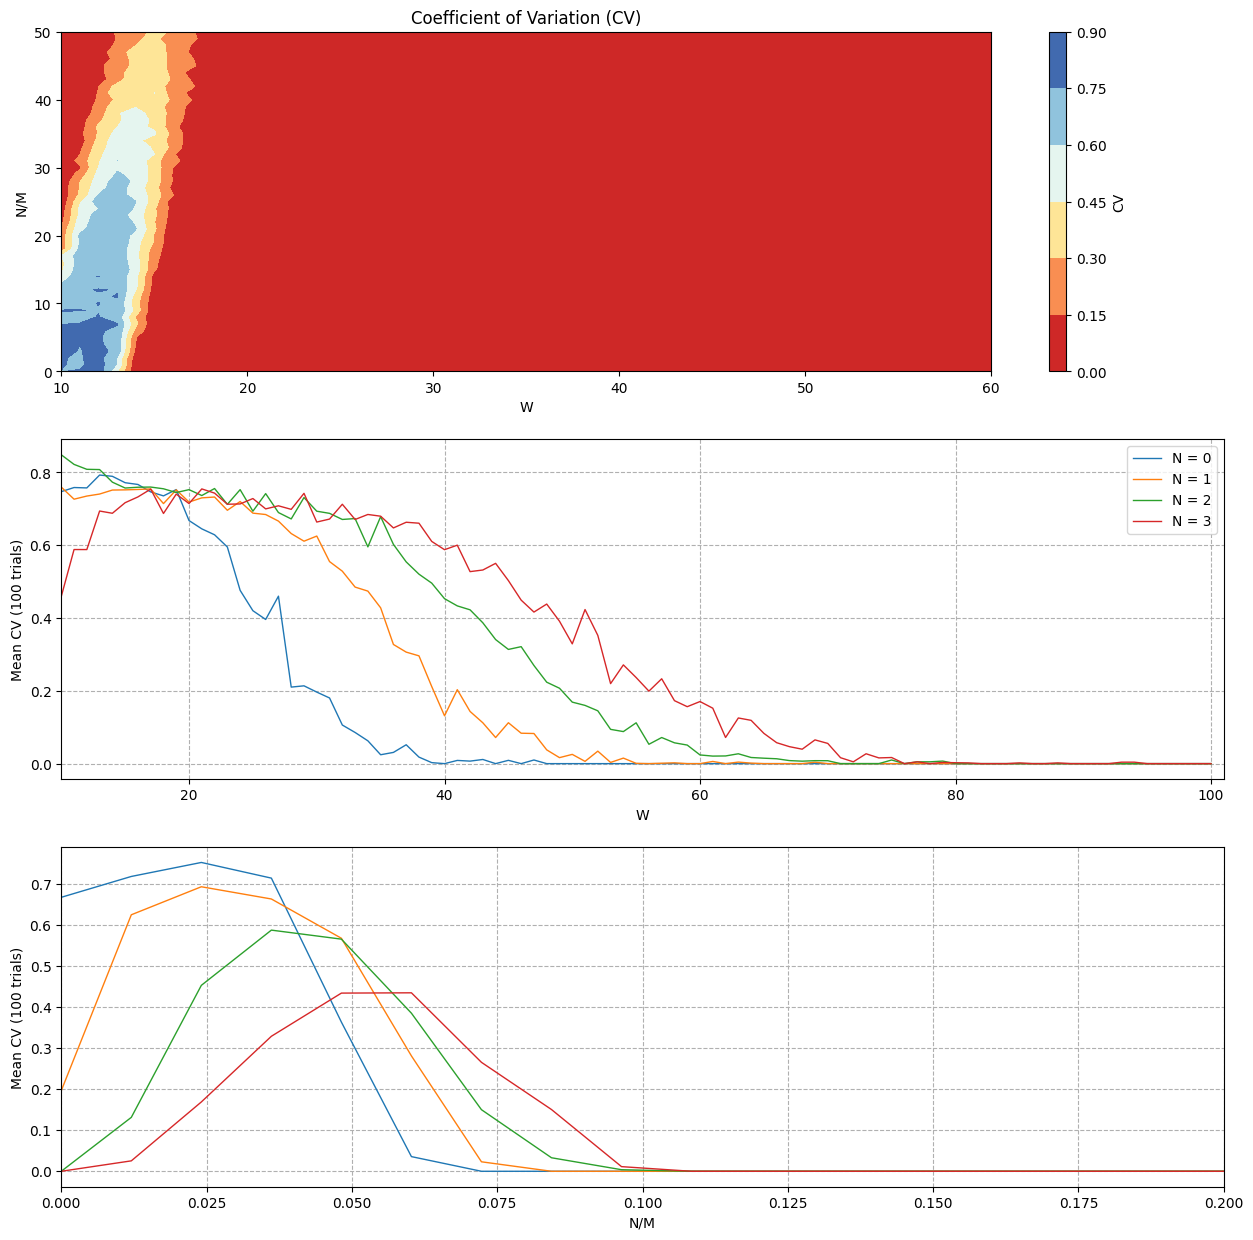

In [33]:
# plot contour
fig, axs = plt.subplots(3, 1, figsize=(15,15))
cs = axs[0].contourf(W[:51], N[:51], CV[:51], cmap='RdYlBu')
axs[0].set_xlabel('W')
axs[0].set_ylabel('N/M')
axs[0].set_title('Coefficient of Variation (CV)')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('CV')

selected = []
for i in range(4):
    axs[1].plot(W, CV[:, i], linewidth=1)
    axs[1].set_xlabel('W')
    axs[1].set_ylabel('Mean CV (100 trials)')
    axs[1].set_xlim(10, 101)
    axs[1].grid(True, which='both', linestyle='--')
    selected.append(i)

axs[1].legend(["N = " + str(selected[0]), "N = " + str(selected[1]), "N = " + str(selected[2]), "N = " + str(selected[3])])
selected = []
for i in range(10, 41, 10):
    axs[2].plot(N/len(spt), CV[i, :], linewidth=1)
    axs[2].set_xlabel('N/M')
    axs[2].set_ylabel('Mean CV (100 trials)')
    axs[2].set_xlim(0, 0.2)
    axs[2].grid(True, which='both', linestyle='--')
    selected.append(i)

Upon increasing the window length, we observe a decrease in the CV value, which is logical because the neuron's behavior tends to be less random as the window length increases. In contrast, a smaller window length leads to a Poisson-like behavior, resulting in higher CV values. As $\frac{N}{M}$ increases, the CV decreases again because a higher N leads to a higher threshold for spiking and a lower probability of spiking, causing the neuron to deviate from random behavior and the CV to decrease. A small N and W result in a coincidence detector neuron that behaves like a Poisson neuron, leading to a higher CV value.

The left plot shows that increasing the value of W results in a decrease in the CV value. This is because as the window length increases, the neuron's behavior becomes less random and more predictable, leading to a decrease in the CV value.

On the right plot, it can be seen that when N is too small, the CV value is low. However, as N increases, the CV value initially rises and then falls, which is a logical outcome. This is because as N increases, the threshold for spiking becomes higher, which reduces the probability of spiking and moves the neuron away from random behavior. Consequently, the CV value increases at first but then starts to decrease as N continues to increase.

---

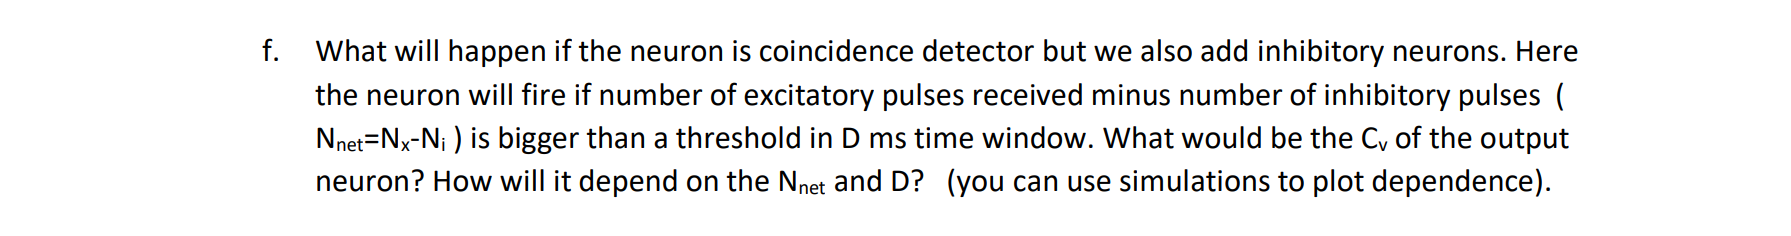

In [ ]:
# part f
Duration = 1e3 # ms
r = 100 # rate of excitatories equals with rate of inhibitories
t0 = 0 # refractory period ms
W = np.arange(10, 101)
N = np.arange(0, int(5*r*max(W)/Duration)+1)
CV = np.zeros((100, len(W), len(N)))

for cv in range(len(CV)):
    tt = 0 # on going time
    t = 0
    cntE = 0
    isiE = [] # isi of Exitatories
    sptE = [] # spike times of Exitatories
    cntI = 0
    isiI = [] # isi of Inhibitories
    sptI = [] # a vector to keep spike times
    spt_final = []
    
    while t < Duration/1000:
        isiE.append(np.random.exponential(1/r) + t0)
        t = t + isiE[cntE]
        sptE.append(t)
        cntE = cntE + 1
    sptE.pop()
    
    t = 0

    while t < Duration/1000:
        isiI.append(np.random.exponential(1/r) + t0)
        t = t + isiI[cntI]
        sptI.append(t)
        cntI = cntI + 1
    sptI.pop()
    
    for w in range(len(W)):
        for n in range(len(N)):
            tt = 0
            spt_final = []
            while tt < Duration:
                NfE = np.where(np.array(sptE)*1000 >= tt)[0]
                NfE = np.where(np.array(sptE)[NfE]*1000 < tt+W[w])[0]
                NfI = np.where(np.array(sptI)*1000 >= tt)[0]
                NfI = np.where(np.array(sptI)[NfI]*1000 < tt+W[w])[0]
                tt = tt+W[w]
                if((len(NfE)-len(NfI)) >= N[n]):
                    spt_final.append(tt/1000)
            if spt_final and len(spt_final) > 1:
                CV[cv,w,n] = np.std(np.diff(spt_final))/np.mean(np.diff(spt_final))

CV = np.mean(CV,0).reshape(len(W),len(N))

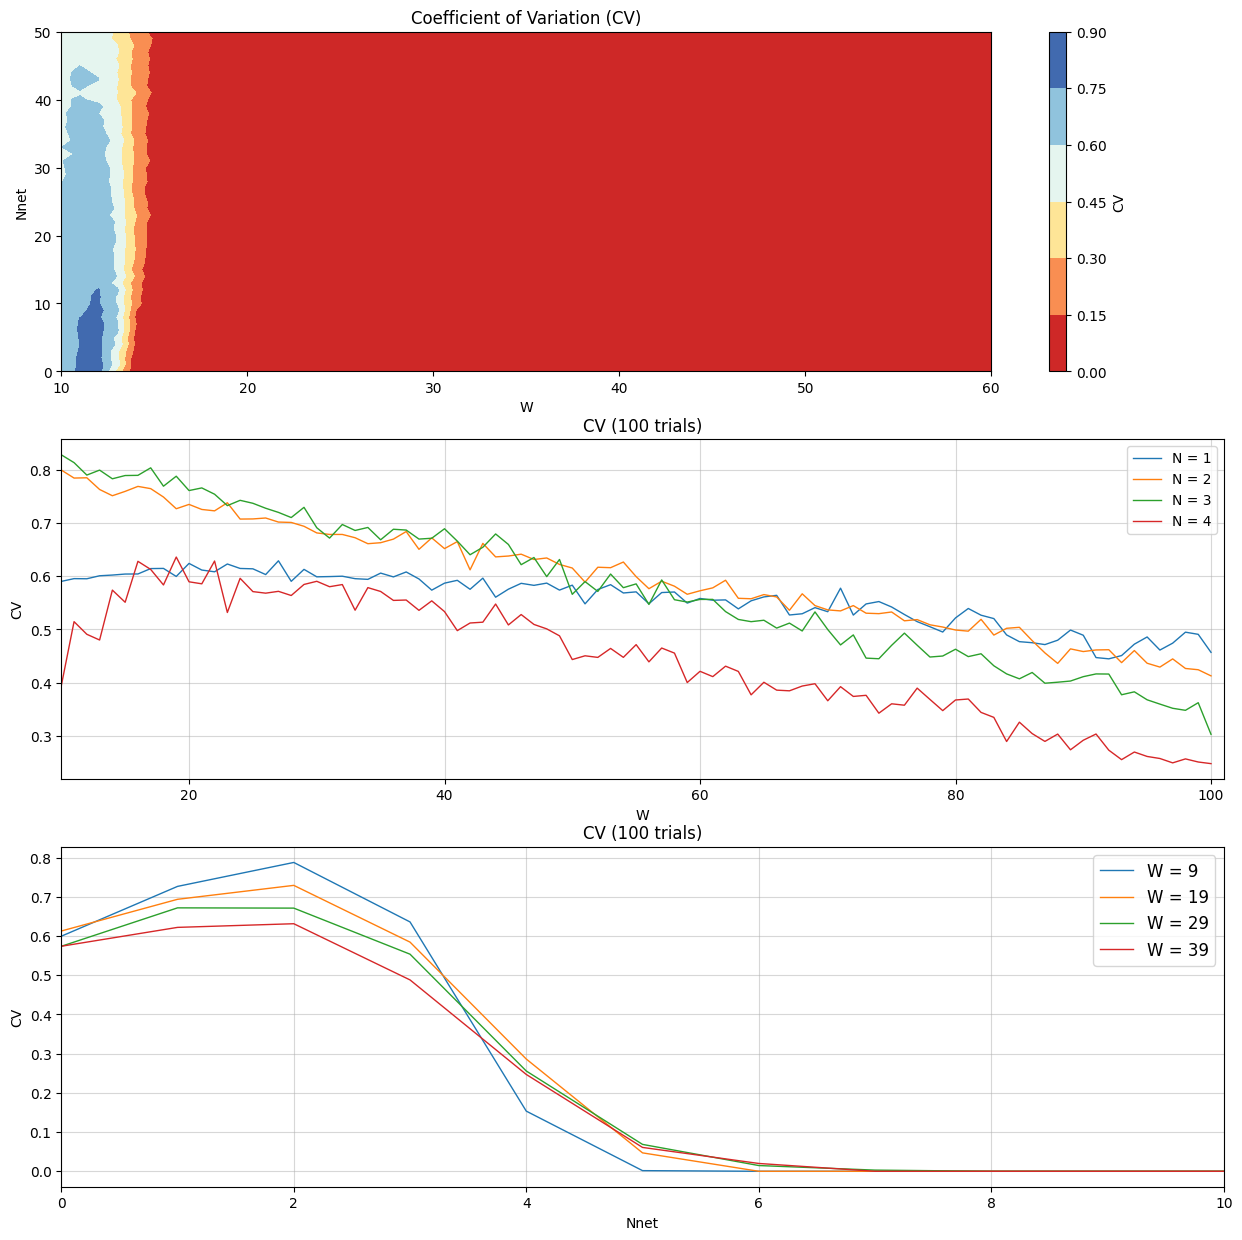

In [49]:
# plot contour
fig, axs = plt.subplots(3, 1, figsize=(15,15))
cs = axs[0].contourf(W[:51], N[:51], CV[:51], cmap='RdYlBu')
axs[0].set_xlabel('W')
axs[0].set_ylabel('Nnet')
axs[0].set_title('Coefficient of Variation (CV)')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('CV')

selected = []
for i in range(4):
    axs[1].plot(W, CV[:,i], label=f"N = {i+1}", linewidth=1)
    axs[1].set_xlabel('W')
    axs[1].set_ylabel('CV')
    axs[1].set_title('CV (100 trials)')
    axs[1].legend()
    axs[1].set_xlim(10, 101)
    axs[1].grid(True, which='both', alpha=0.5)
    selected.append(i+1)

selected2 = []
for i in range(9, 41, 10):
    axs[2].plot(N, CV[i,:], label=f"W = {i}", linewidth=1)
    axs[2].set_xlabel('Nnet')
    axs[2].set_ylabel('CV')
    axs[2].set_title('CV (100 trials)')
    axs[2].set_xlim(0, 10)
    axs[2].legend(fontsize=12)
    axs[2].grid(True, which='both', alpha=0.5)
    selected2.append(i)
plt.show()

Increasing the value of w leads to a decrease in CV, while increasing the value of Nnet results in an initial increase followed by a decrease in CV.